## Annual Compensation Prediction for Data Scientist
### PayUP

Data Citations: 
  - https://insights.stackoverflow.com/survey?_ga=2.11789565.810797287.1632789089-1845374821.1632789089

### Objective: 

- The main motivation for this project is to create machine learning models that help data scientists identify a salary range for their salary negotiations when looking for or switching jobs. The objective is to predict annual compensation bands based on specific features such as the number of years with professional coding experience, education level, data science skill sets (i.e. programming languages known, web frameworks learned, database, etc.) and other demographics information.
- Other companies such as Payscale and Salary.com are doing similar work. One difference is that these companies collect more data as people use their services. Whereas, this project focus on making a generic baseline model using open source data which is the annual salary survey conducted by StackOverflow for Developers for year 2021, 2020 and 2019 from over 180 countries. 
<br><br>

### Project Summary
- *Outcome Variable*: used the raw data of annual compensation values from 0 - 250,000 USD (continuous scale).
<br>

- *Model Evaluation Objective*: find the best model with highest R-squared score, and lowest Root Mean Square Error (RMSE).
<br><br>

#### Baseline Model
- Using Linear Regression with all 75 features for all countries in the dataset. 
- Baseline model performance:

|       Model       | RMSE Dev Data | R2 Score Dev Data |
|:------------------|--------------:|------------------:|
| Linear Regression |     30,144.14 |             0.632 |

<br><br>

#### Best Model
- Using XGBoost Regressor with all 75 features for all countries in the dataset. 
- Best model performance:

<br>

|       Model          | RMSE Test Data | R2 Score Test Data |
|:---------------------|---------------:|-------------------:|
| XGBoosting Regressor |      26,919.16 |              0.714 |

<br>

|         Model        | RMSE Dev Data | R2 Score Dev Data |                                      Hyperparameters Tuning                                 |
|:---------------------|--------------:|------------------:|:--------------------------------------------------------------------------------------------|
| XGBoosting Regressor |     29,166.97 |             0.656 | max_depth=10, n_estimators=150, <br>colsample_bytree=0.5, lambda=100, <br>learning_rate=0.1 |

<br><br>

####  Model Comparison
Different models were built and evaluated, summary of these models with hyperparameters tuning are as following. 
- For the continuous outcome variable: 

| Model                                   | RMSE Dev Data | R2 Score Dev Data | Hyperparameters Tuning                                                                                        |
|-----------------------------------------|--------------:|------------------:|---------------------------------------------------------------------------------------------------------------|
| XGBoosting Regressor (Best Model)       |     29,166.97 |             0.656 | max_depth=10, n_estimators=150, <br>colsample_bytree=0.5, lambda=100, <br>learning_rate=0.1                 |
| OLS Regression (Baseline)               |     30,144.14 |             0.632 |                                                                                                               |
| OLS Regression Log Transformed          |     32,153.94 |             0.495 |                                                                                                               |
| Ridge Regression                        |     30,161.06 |             0.632 | alpha=2                                                                                                       |
| Lasso Regression                        |     30,144.72 |             0.632 | alpha=10                                                                                                      |
| Random Forest Regressor                 |     29,907.63 |             0.638 | max_depth=30, n_estimators=150,<br>min_samples_split=30, min_samples_leaf=3                                 |
| ADA Boosting Regressor                  |     29,986.60 |             0.636 | max_depth=30, n_estimators=150,<br>min_samples_split=20, min_samples_leaf=3                                 |
| Gradient Boosting Regressor             |     29,683.04 |             0.644 | max_depth=3, n_estimators=150, <br>min_samples_split=20, min_samples_leaf=5                               |
| Support Vector Regressor                |     30,439.58 |             0.625 | kernel=linear, C=100, epsilon=0.001                                                                           |
| Regression with PCA                     |     31,449.84 |             0.600 | n_components = 50                                                                                             |
| XGBoosting Regressor with PCA           |     30,720.91 |             0.618 | n_components = 50, max_depth=3, <br>colsample_bytree=0.3, lambda=1,   <br>learning_rate=0.3, n_estimators=150 |
| Regression with Top n Important Features |     30,311.20 |             0.628 | n_features=50                                                                                                 |

<br><br>

#### Limitation
- I've looked at subsetting the data for United States, however, the predicting power - RMSE and R2 score performance was much lower than using all countries. The limitation was due to lacking of several key features like State, industry information and number of working hours weekly in the dataset, and low sample counts which could result in high bias and underfitting in our models.  
- The models are sensitive with out-liers, records with salary over 250,000 USD negatively impact the performance of the models and therefore we decided to drop them from our model data. 

### Step 1: Import packages

In [101]:
# general
import io
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import requests
from requests.auth import HTTPBasicAuth
import warnings
warnings.filterwarnings('ignore')
import re

# plots
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix

# predictions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
sns.set_theme(color_codes=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Step 2: Define Functions for Data Cleaning & Processing

#### 2.1. Ordinal or Continuous Features: 
- The data were generated by merging the survey data for 3 years (2021, 2020 and 2019). The format and schema for some variables in the 3 years data are different. Therefore, new features were created for converting ordinal scale with following functions.
- The null/missing values were handled by removing them from the dataset, or replacing with median value.

In [3]:
#Function to recode Age variable
def ActualAge(age):
    if isinstance(age, float):
        int_age = int(age)
        age = str(int_age)
        if int(age) < 18:
            return age.replace(age, 'Under 18 years old')
        elif int(age) < 25:
            return age.replace(age, '18-24 years old')
        elif int(age) < 35:
            return age.replace(age, '25-34 years old')
        elif int(age) < 45:
            return age.replace(age, '35-44 years old')
        elif int(age) < 55:
            return age.replace(age, '45-54 years old')
        elif int(age) < 65:
            return age.replace(age, '55-64 years old')
        else:
            return age.replace(age, '65 years or older')
    elif isinstance(age, str):
        if age == 'Prefer not to say':
            return np.nan
        else:
            return age
    else:
        return age
    
#Function to recode Age1stCode variable
def MapAge(age):
    a1 = -1
    if int(age) < 5:
        a1 = age.replace(age, 'Younger than 5 years')
    elif int(age) < 11:
        a1 = age.replace(age, '5 - 10 years')
    elif int(age) < 18:
        a1 = age.replace(age, '11 - 17 years')
    elif int(age) < 25:
        a1 = age.replace(age, '18 - 24 years')
    elif int(age) < 35:
        a1 = age.replace(age, '25 - 34 years')
    elif int(age) < 45:
        a1 = age.replace(age, '35 - 44 years')
    elif int(age) < 55:
        a1 = age.replace(age, '45 - 54 years')
    elif int(age) < 65:
        a1 = age.replace(age, '55 - 64 years')
    else:
        a1 = age.replace(age, 'Older than 64')
    return a1

#Function to recode YearsCode variable
def MapYearsCode(years):
    yr = -1
    if int(years) < 2:
        yr = years.replace(years, 'Less than 2 years')
    elif int(years) < 5:
        yr = years.replace(years, '2 - 5 years')
    elif int(years) < 10:
        yr = years.replace(years, '6 - 10 years')
    elif int(years) < 20:
        yr = years.replace(years, '11 - 20 years')
    elif int(years) < 30:
        yr = years.replace(years, '21 - 30 years')
    else:
        yr = years.replace(years, 'greater than 30 years')
    return yr

#Function to create compensation bracket variable
def CompBracket(comp):
    comp = str(comp)
    if int(comp) < 10000:
        c = comp.replace(comp, '0 - 9999')
    elif int(comp) < 20000:
        c = comp.replace(comp, '10000 - 19999')
    elif int(comp) < 30000:
        c = comp.replace(comp, '20000 - 29999')
    elif int(comp) < 40000:
        c = comp.replace(comp, '30000 - 39999')
    elif int(comp) < 50000:
        c = comp.replace(comp, '40000 - 49999')
    elif int(comp) < 60000:
        c = comp.replace(comp, '50000 - 59999')
    elif int(comp) < 70000:
        c = comp.replace(comp, '60000 - 69999')
    elif int(comp) < 80000:
        c = comp.replace(comp, '70000 - 79999')
    elif int(comp) < 100000:
        c = comp.replace(comp, '80000 - 99999')
    elif int(comp) < 120000:
        c = comp.replace(comp, '100000 - 119999')
    elif int(comp) < 140000:
        c = comp.replace(comp, '120000 - 139999')
    elif int(comp) < 160000:
        c = comp.replace(comp, '140000 - 159999')
    elif int(comp) < 200000:
        c = comp.replace(comp, '160000 - 199999')
    elif int(comp) < 250000:
        c = comp.replace(comp, '200000 - 249999')
    elif int(comp) >= 250000:
        c = comp.replace(comp, '+250000')
    return c

#Function to create high, medium low compensation brackets
def CompBracket_HML(comp):
    comp = str(comp)
    if int(comp) < 27220:
        c = comp.replace(comp, 'Low')
    elif int(comp) < 94495:
        c = comp.replace(comp, 'Medium')
    else:
        c = comp.replace(comp, 'High')
    return c

def education_clean(x):
    education_dict = {"missing":np.nan,
                  'Something else':np.nan,
                  'I never completed any formal education':1,
                  'Primary/elementary school':1,
                  'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':1,
                  'Some college/university study without earning a degree':1, 
                  'Associate degree (A.A., A.S., etc.)': 2,
                  'Associate degree':2,
                  'Bachelor’s degree (B.A., B.S., B.Eng., etc.)':3,
                  'Bachelor’s degree (BA, BS, B.Eng., etc.)':3,
                  'Professional degree (JD, MD, etc.)':4,
                  'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':5,
                  'Master’s degree (MA, MS, M.Eng., MBA, etc.)':5,
                  'Other doctoral degree (Ph.D., Ed.D., etc.)':6
                 }
    return x.map(education_dict)

def CleanAgeAndYearsCode(data, age_categories, cat_yc, cat_org):
    ''' Cleans the columns in col_list and combines categories for data processing
    '''
    col_list = ['Age1stCode', 'YearsCode', 'YearsCodePro', 'OrgSize']
    
    #Store the master data into a working array
    working_clean = data
    
    #Remove null values from each category in col_list
    for col in col_list:
        working_clean = working_clean[working_clean[col].notnull()]

    #Clean up extranueous categories
    #Combining categories in Age1stCode
    working_clean.loc[working_clean['Age1stCode'] == 'Older than 85', 'Age1stCode'] = 'Older than 64 years'
    
    #Separate out categories from numerical values
    clean_age = working_clean[working_clean['Age1stCode'].isin(age_categories)]
    fix_age = working_clean[~working_clean['Age1stCode'].isin(age_categories)]

    #Categorize ages that are not already in a category
    #Combine the two separated lists to reform the working_clean array
    fix_age['Age1stCode'] = fix_age['Age1stCode'].apply(MapAge)
    working_clean = clean_age.append(fix_age, sort=False)
   
    print('Age1stCode')
    print(working_clean['Age1stCode'].value_counts())

    #Cleaning categories for YearsCode by combing specific categories to improve dataset
    working_clean.loc[working_clean['YearsCode'] == 'Older than 64 years'] = '64'
    working_clean.loc[working_clean['YearsCode'] == 'More than 50 years'] = '50'
    working_clean.loc[working_clean['YearsCode'] == 'Less than 1 year'] = '1'
    working_clean = working_clean.astype({"YearsCode":"int"})

    print('\nYears Code')
    print(working_clean['YearsCode'].describe())
        
    #Cleaning categories for YearsCodePro
    working_clean['YearsCodePro'].replace({'Less than 1 year':1,'More than 50 years':50}, inplace=True)
    working_clean = working_clean.astype({"YearsCodePro":"int"})   

    print('\nYearsCodePro')
    print(working_clean['YearsCodePro'].describe())
    
    #Cleaning categories for OrgSize
    working_clean = working_clean[working_clean['OrgSize'] != 'I don’t know']
    working_clean.loc[working_clean['OrgSize'] == 'Just me - I am a freelancer, sole proprietor, etc.', 'OrgSize'] = '1'
    working_clean.loc[working_clean['OrgSize'] == '2-9 employees', 'OrgSize'] = '2 to 9 employees'
    working_clean.loc[working_clean['OrgSize'] == '50', 'OrgSize'] = '20 to 99 employees'
    working_clean.loc[working_clean['OrgSize'] == '64', 'OrgSize'] = '20 to 99 employees'
    working_clean.loc[working_clean['OrgSize'] == '1', 'OrgSize'] = '1 employee'
    
    print('\nOrgSize')
    print(working_clean['OrgSize'].value_counts())
    print('\n')
    
    return working_clean

def CleanActualAgeCountryYearlyComp(data, age_cat):
    ''' Cleans the columns in col_list and combines categories for data processing for Age, Compensation and Country
    '''
    col_list = ['Age', 'ConvertedCompYearly', 'Country',]
    
    #Store the master data into a working array
    working_clean = data
    
    #Remove null values from each category in col_list
    for col in col_list:
        working_clean = working_clean[working_clean[col].notnull()]
    
    #map integers to strings
    working_clean['Age'].replace({1:'Under 18 years old','1':'Under 18 years old', 2:'18-24 years old', 3:'25-34 years old',
                         4:'35-44 years old', 5:'45-54 years old', 6:'55-64 years old',
                         7:'65 years or older', '50':'45-54 years old'}, inplace=True)
    #map floats to strings
    working_clean['Age'] = working_clean['Age'].apply(ActualAge)
   
    print('Age')
    print(working_clean['Age'].value_counts())
    
    #convert compensation to integer
    working_clean['ConvertedCompYearly'] = working_clean['ConvertedCompYearly'].astype('int64')
    
    #Apply the CompBracket function to create compensation brackets
    working_clean['Comp_Bracket'] = working_clean['ConvertedCompYearly'].apply(CompBracket)
    working_clean['Comp_Bracket_HML'] = working_clean['ConvertedCompYearly'].apply(CompBracket_HML)
    
    print('\nYearly Compensation')
    print(working_clean['ConvertedCompYearly'].value_counts().sort_values(ascending=False)[:5])
    
    print('\nYearly Compensation Bracket')
    print(working_clean['Comp_Bracket'].value_counts())
    
    print('\nYearly Compensation Bracket')
    print(working_clean['Comp_Bracket_HML'].value_counts())
    
    #combine countries with different names
    working_clean['Country'].replace({'United States of America':'United States', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                           'Iran, Islamic Republic of...':'Iran', 'Republic of Korea': 'South Korea', 'Syrian Arab Republic': 'Syria', 'Russian Federation':'Russia',
                          'Venezuela, Bolivarian Republic of...':'Venezuela', 'The former Yugoslav Republic of Macedonia': 'Macedonia',
                            'United Republic of Tanzania':'Tanzania'}, inplace = True)
    
    print('\nTop 5 Country with most records')
    print(working_clean['Country'].value_counts()[:5])
    
    return working_clean

def MappingOrdinal(data):
    ''' Mapping ordinal columns'''
    age_mapping = {'Under 18 years old':1, '18-24 years old':2, '25-34 years old':3,
                         '35-44 years old':4, '45-54 years old':5, '55-64 years old':6, '65 years or older':7}
    comp_mapping = {'0 - 9999':1, '10000 - 19999':2, '20000 - 29999':3, '30000 - 39999':4,
                    '40000 - 49999':5, '50000 - 59999':6, '60000 - 69999':7, '70000 - 79999':8,
                    '80000 - 99999':9, '100000 - 119999':10, '120000 - 139999':11, '140000 - 159999':12,
                    '160000 - 199999':13, '200000 - 249999':14, '+250000':15}
    comp_mapping_hml = {'Low':1, 'Medium':2, 'High':3}
    orgsize_mapping = {label:idx for idx, label in enumerate(cat_orgsize)}
    age1stcode_mapping = {label:idx for idx, label in enumerate(cat_age)}
    
    #Assign data
    data_map = data
    
    #Map age
    data_map['Age'] = data_map['Age'].map(age_mapping)
    
    #Map Compensation Bracket
    data_map['Comp_Bracket'] = data_map['Comp_Bracket'].map(comp_mapping)
    
    #Map Comp Bracket High, Medium, Low
    data_map['Comp_Bracket_HML'] = data_map['Comp_Bracket_HML'].map(comp_mapping_hml)
    
    # Map OrgSize
    data_map['OrgSize'] = data_map['OrgSize'].map(orgsize_mapping)
    
    # Map Years Code
    data_map['Age1stCode'] = data_map['Age1stCode'].map(age1stcode_mapping)
    
    # Convert Comp_Bracket to int for running classification
    data_map = data_map[data_map['Comp_Bracket'].notna()]
    data_map = data_map[data_map['Age'].notna()]
    data_map = data_map.astype({"Comp_Bracket":"int", "Age":"int"})
    
    return data_map

In [4]:
#Actual age categories
age_cat = ['Under 18 years old', '18-24 years old','25-34 years old', '35-44 years old',
            '45-54 years old', '55-64 years old','65 years or older']

#Compensation Brackets lables
comp_cat = ['0 - 9999', '10000 - 19999', '20000 - 29999', '30000 - 39999',
    '40000 - 49999', '50000 - 59999', '60000 - 69999', '70000 - 79999',
    '80000 - 99999', '100000 - 119999', '120000 - 139999', '140000 - 159999',
    '160000 - 199999', '200000 - 249999', '+250000']

#Categories for years when the surveyee first started to code
cat_age = ['Younger than 5 years', '5 - 10 years', '11 - 17 years', '18 - 24 years',
              '25 - 34 years','35 - 44 years', '45 - 54 years', '55 - 64 years', 'Older than 64 years']

#Categories for years coded
cat_years = ['Less than 2 years', '2 - 5 years', '6 - 10 years', '11 - 20 years',
              '21 - 30 years','greater than 30 years'] 

#Categories for organization size
cat_orgsize = ['1 employee', '2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees',
       '500 to 999 employees','1,000 to 4,999 employees','5,000 to 9,999 employees','10,000 or more employees']


#### 2.2. Data Science Skills Features : 
- To process different skills for data scientist, they were grouped into different categories. Then, I calculated the total number of skills that the person has in each category. For example, the number of data science scripting languages (reference: [Top Data Science Programing Languages](https://intellipaat.com/blog/data-science-programming-languages/)), the number of web development languages or framework that a person knows, etc.
- We use ordinal scale for these skillsets instead of using one-hot encoding to binary features for each feature, as this helps reduce the feature numbers of the model and reduce overfitting.

In [5]:
## Functions for cleaning Skills columns and grouping of skillsets
def vectorizer(column, df):
    '''Function to convert the skill column to word vectors'''
    # replace null value to the string "NA", since vectorizer couldn't take on empty string
    languages = list(df[column].replace(np.nan, "na").values)
    
    # Use Count vectorizer to create a bag of word
    count = CountVectorizer(tokenizer=tokenizer,
                            lowercase=False,
                            stop_words = ["Other","na"],
                           )
    X_vect = count.fit_transform(languages).toarray()
    X_names = count.get_feature_names()
    
    # Replace repeated values to 1 if a same language is listed >1 times (count >1) for a person
    X_vect = np.where(X_vect >= 1, 1, 0)
    
    return X_vect, X_names
    
    
def clean_up_text(text):
    '''Clean up text in the skill columns'''
    
    ## Clean data for languageHaveWorkedWith
    # Split Bash/Shell/Powershell to Bash/Shell (Linux) & Powershell(window)
    # Because Powershell is also listed by in self in some record
    text = re.sub(r'/(?=PowerShell)', ';', text)
    # Remove (s) from Other(s):
    text = re.sub(r'\(s\)','', text)
    
    ## Clean data for DatabaseHaveWorkedWith
    # Replace whitespace by "_" for not splitting
    text = re.sub(r'\s','_', text)
    
    ## Clean data for WebframeHaveWorkedWith
    # Standardize all versions of ASP.NET
    text = re.sub(r'(?<=ASP.NET)_Core_?','',text)
    # Standardize all versions of Angular.js
    text = re.sub(r'Angular(?!.js)','Angular.js', text)
    
    ## Clean data for MiscTechHaveWorkedWith
    # Standardize all .NET_Core, .NET_5, .NET_Framework versions to .NET
    text = re.sub(r'(?<=.NET)((_Core)(_/_.NET_5)?|_Framework)','',text)
    
    return text
    
    
def tokenizer(text):
    '''Custom tokenizer function with clean_up text data before processing'''
    # Remove null values and Other from bag of word
    return [w.strip(':').strip() for w in clean_up_text(text).split(';')]


def show_texts(column, df):
    '''Show all languages with their frequency in the data set using WordCloud'''
    # Replace null value to the string "NA"
    languages = list(df[column].replace(np.nan, "na").values)
    
    # Combine all rows to a string/ document & apply clean up
    text = ';'.join(languages)
    text = clean_up_text(text)
    
    # create a word cloud
    word_cloud = WordCloud(background_color='white',
                           collocations=False,
                           relative_scaling = 0.3,
                           regexp = r"[\w/#+-.]+",  # Keep words & these special characters
                           stopwords={'na','other'})  # Do not create null & other column
    
    # Display word cloud
    word_cloud.generate(text)
    fig = plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

def show_distribution(column, df):
    '''Function return the count of each word vector (skills) in the dataframe'''
    language_vects, language_names = vectorizer(column, df)
    counts = np.sum(language_vects, axis=0)
    df2 = pd.DataFrame([language_names, counts]).T
    df2.columns = ['language_names', 'counts']
    df2.sort_values('counts', ascending=False, inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    return df2


def process_skills(df):
    '''Process all the skill columns from the dataframe, split each skill to a new binary column
    and return as a new dataframe'''
    
    # Clean up texts & vectorize each skill column
    language_vects, language_names = vectorizer('LanguageHaveWorkedWith', df)
    database_vects, database_names = vectorizer('DatabaseHaveWorkedWith', df)
    platform_vects, platform_names = vectorizer('PlatformHaveWorkedWith', df)
    web_vects, web_names = vectorizer('WebframeHaveWorkedWith', df)
    misc_vects, misc_names = vectorizer('MiscTechHaveWorkedWith', df)
    
    # Return new DataFrame
    df_skills = pd.DataFrame(np.hstack((language_vects, database_vects,
                                       platform_vects, web_vects, misc_vects)))
    columns = list(np.hstack((language_names, database_names, platform_names,
                             web_names, misc_names)))
    df_skills.columns = columns
    
    return df_skills

def grouping_skills(df):
    '''Grouping the skill sets together by categories, 
    return the number of tools in each categories that the person knows'''
    df.reset_index(drop=True, inplace=True)
    df2 = process_skills(df)
    
    # Define skill categories
    skills = {'language_DS': ['C', 'C++', 'Java', 'JavaScript', 'Julia', 'Matlab','Python', 'R', 'SQL'],
              'language_others': ['APL', 'C#', 'COBOL', 'Clojure', 'Crystal',
                                      'Delphi', 'Elixir', 'Erlang', 'F#', 'Go', 'Groovy',
                                      'Haskell', 'Kotlin', 'LISP','Objective-C', 'Ruby', 'Rust',
                                      'Swift', 'TypeScript','VBA','Assembly', 'WebAssembly'],
              'command_line': ['Bash/Shell', 'PowerShell'],
              'web_dev': ['HTML/CSS', 'PHP', 'Node.js','.NET'],
              'sql_database': ['IBM_DB2', 'MariaDB', 'Microsoft_SQL_Server', 'MySQL',
                                'Oracle', 'PostgreSQL', 'SQLite'],
              'nosql_database': ['Cassandra', 'Couchbase', 'DynamoDB', 'Elasticsearch', 
                                 'Firebase', 'MongoDB', 'Redis'],
              'cloud_computing': ['AWS', 'DigitalOcean', 'Google_Cloud_Platform', 'Heroku',
                                  'IBM_Cloud_or_Watson', 'Microsoft_Azure', 'Oracle_Cloud_Infrastructure'],
              #'operating_system': ['Android', 'Linux', 'MacOS', 'Windows', 'iOS'],
              'elec_platform': ['Arduino', 'Raspberry_Pi'],
              'container_platform': ['Docker', 'Kubernetes'],
              'web_framework': ['WordPress', 'ASP.NET', 'Angular.js', 'Django', 'Drupal',
                                'Express', 'FastAPI', 'Flask', 'Gatsby', 'Laravel', 
                                'React.js', 'Ruby_on_Rails', 'Spring', 'Svelte', 'Symfony',
                                'Vue.js', 'jQuery'],
              'ML_tools': ['Apache_Spark', 'Keras','TensorFlow', 'Torch/PyTorch'],
              'app_UI_dev': ['Dart', 'Ansible', 'Cordova', 'CryEngine', 'Flutter', 'Qt', 
                             'React_Native', 'Unity_3D', 'Unreal_Engine', 'Xamarin'],
              'server_dist_config': ['Chef', 'Hadoop', 'Puppet', 'Teraform']
             }
    
    # Grouping skills
    for key, value in skills.items():
        df[key] = df2[value].sum(axis=1)
    
    return df

#### 2.3. Categorical Features: 
- I standardized the data for the following categorical variables and create one-hot encoding features for them.
- The null/missing values were handled by either removing them from the dataset, or replacing with the mode or mean value.

In [6]:
# Categorical Data Cleaning Functions:
def gender_bin(x):
    if x == "Man":
        return 1
    else:
        return 0

def gender_bin_woman(x):
    if x == 'Woman':
        return 1
    else:
        return 0

def employ(x):
    if x == "Employed full-time":
        return 1
    else:
        return 0

def employ_parttime(x):
    if x == "Employed part-time":
        return 1
    else:
        return 0
    
def employ_others(x):
    if x == "Independent contractor, freelancer, or self-employed":
        return 1
    else:
        return 0
    
def white(x):
    if "White or of European descent" in x:
        return 1
    else:
        return 0
    
def asian(x):
    if "Asian" in x:
        return 1
    else:
        return 0
    
def hispanic(x):
    if "Hispanic" in x:
        return 1
    else:
        return 0
def black(x):
    if "Black" in x:
        return 1
    else:
        return 0
    
def mideast(x):
    if "Middle Eastern" in x:
        return 1
    else:
        return 0
    
def biracial(x):
    if "Multiracial" in x:
        return 1
    if "Biracial" in x:
        return 1
    else:
        return 0
    
def straight(x):
    if "Straight" in x:
        return 0
    else:
        return 1
    
def trans(x):
    if "No" in x:
        return 0
    else:
        return 1 

def MappingCategorical(master):
    '''Input data frame, create new columns to convert categorical variables'''
    # Code block for pulling running the dataframe through the functions:
    # Gender, records with "not man or woman" will be 0 for both man & woman 
    master['Gender'] = ['missing' if i is np.nan else i for i in master['Gender']]
    master["man"] = master["Gender"].apply(gender_bin)
    master["woman"] = master["Gender"].apply(gender_bin_woman)

    # Sexuality
    master['Sexuality'] = ['missing' if i is np.nan else i for i in master['Sexuality']]
    master["sexualitycat"] = master["Sexuality"].apply(straight)
    
    # Trans Gender
    master['Trans'] = ['missing' if i is np.nan else i for i in master['Trans']]
    master['transbin'] = master['Trans'].apply(trans)

    # Education
    master['EdLevel'] = ['missing' if i is np.nan else i for i in master['EdLevel']]
    master['ed_ordinal'] = education_clean(master['EdLevel'])
    # replace null values with median
    master['ed_ordinal'].fillna(master['ed_ordinal'].median(), inplace=True)

    # Employment status
    master['Employment'] = ['missing' if i is np.nan else i for i in master['Employment']]
    master['employ'] = master['Employment'].apply(employ)  # full-time position
    master['employ_parttime'] = master['Employment'].apply(employ_parttime)   # part-time position
    # Self-employed or freelance, independent contractor will be 0 for both 'employ' & 'employ_parttime' 

    # Ethnicity
    master['Ethnicity'] = ['missing' if i is np.nan else i for i in master['Ethnicity']]

    # White
    master['white'] = master['Ethnicity'].apply(white)

    # Asian
    master['asian'] = master['Ethnicity'].apply(asian)

    # Black
    master["black"] = master['Ethnicity'].apply(black)

    # Middle Eastern
    master['mideast'] = master['Ethnicity'].apply(mideast)

    # Hispanic
    master['hispanic'] = master['Ethnicity'].apply(hispanic)

    # Non specified bi-racial
    master['biracial'] = master['Ethnicity'].apply(biracial)
    
    # Survey year
    # Drop row doesn't have a year
    master = master.astype({"SurveyYear":"int",'ed_ordinal':"int" })
    master = master[master['SurveyYear'] >= 2019]
    # Create dummies columns
    year_dummies = pd.get_dummies(master.SurveyYear, drop_first=True)
    master = pd.concat((master, year_dummies), axis=1)
    
    # Countries
    # Grouping all countries having less than 30 records to 'OtherCountry' group
    country_count = master.Country.value_counts()
    country_others = [key for key in country_count.index if country_count[key] <= 30] 
    master['Country'] = master['Country'].apply(
        lambda x: "OtherCountry" if x in country_others else x)
    # Create dummies columns
    country_dummies = pd.get_dummies(master.Country)
    master = pd.concat((master, country_dummies), axis=1)
    # Drop OtherCountry dummy column
    master.drop('OtherCountry', axis=1, inplace=True)
    
    # Report Compensation by weekly or monthly or yearly
    compfreq_dummies = pd.get_dummies(master.CompFreq, drop_first=True)
    master = pd.concat((master, compfreq_dummies), axis=1)
    master.reset_index(drop=True, inplace=True)

    return master

### Step 3: Read Data, Cleaning and Preprocessing 

In [7]:
url_2021 = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2021.zip'
url_2020 = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2020.zip'
url_2019 = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2019.zip'

response = requests.get(url_2021, stream=True, verify=False)
with ZipFile(io.BytesIO(response.content)) as myzip:
    with myzip.open(myzip.namelist()[2]) as myfile:
        df_2021 = pd.read_csv(myfile)

response = requests.get(url_2020, stream=True, verify=False)
with ZipFile(io.BytesIO(response.content)) as myzip:
    with myzip.open(myzip.namelist()[2]) as myfile:
        df_2020 = pd.read_csv(myfile)

response = requests.get(url_2019, stream=True, verify=False)
with ZipFile(io.BytesIO(response.content)) as myzip:
    with myzip.open('survey_results_public.csv') as myfile:
         df_2019 = pd.read_csv(myfile)

#### 3.1. Raw data overview
- Some columns have different data schema and column names in the three years data
- Only 2021 data have information about US State, therefore it could not be used as a feature in our model data, due to not having enough records.

In [9]:
# Raw data 2021 survey overview
df_2021.head(3)


ResponseId                                         MainBranch  \
0           1                     I am a developer by profession   
1           2             I am a student who is learning to code   
2           3  I am not primarily a developer, but I write co...   

                                          Employment             Country  \
0  Independent contractor, freelancer, or self-em...            Slovakia   
1                                 Student, full-time         Netherlands   
2                                 Student, full-time  Russian Federation   

  US_State UK_Country                                            EdLevel  \
0      NaN        NaN  Secondary school (e.g. American high school, G...   
1      NaN        NaN       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2      NaN        NaN       Bachelor’s degree (B.A., B.S., B.Eng., etc.)   

      Age1stCode                                          LearnCode YearsCode  \
0  18 - 24 years  Coding Bootcamp;Other online resources (ex: vi...       NaN   
1  11 - 17 years  Other online resources (ex: videos, blogs, etc...         7   
2  11 - 17 years  Other online resources (ex: videos, blogs, etc...       NaN   

  YearsCodePro            DevType             OrgSize           Currency  \
0          NaN  Developer, mobile  20 to 99 employees  EUR European Euro   
1          NaN                NaN                 NaN                NaN   
2          NaN                NaN                 NaN                NaN   

   CompTotal CompFreq                         LanguageHaveWorkedWith  \
0     4800.0  Monthly  C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift   
1        NaN      NaN                              JavaScript;Python   
2        NaN      NaN                       Assembly;C;Python;R;Rust   

  LanguageWantToWorkWith DatabaseHaveWorkedWith DatabaseWantToWorkWith  \
0                  Swift      PostgreSQL;SQLite                 SQLite   
1                    NaN             PostgreSQL                    NaN   
2      Julia;Python;Rust                 SQLite                 SQLite   

  PlatformHaveWorkedWith PlatformWantToWorkWith WebframeHaveWorkedWith  \
0                    NaN                    NaN        Laravel;Symfony   
1                    NaN                    NaN   Angular;Flask;Vue.js   
2                 Heroku                    NaN                  Flask   

  WebframeWantToWorkWith                 MiscTechHaveWorkedWith  \
0                    NaN                                    NaN   
1                    NaN                                Cordova   
2                  Flask  NumPy;Pandas;TensorFlow;Torch/PyTorch   

                        MiscTechWantToWorkWith ToolsTechHaveWorkedWith  \
0                                          NaN                     NaN   
1                                          NaN         Docker;Git;Yarn   
2  Keras;NumPy;Pandas;TensorFlow;Torch/PyTorch                     NaN   

  ToolsTechWantToWorkWith                       NEWCollabToolsHaveWorkedWith  \
0                     NaN                                     PHPStorm;Xcode   
1                     Git          Android Studio;IntelliJ;Notepad++;PyCharm   
2                     NaN  IPython/Jupyter;PyCharm;RStudio;Sublime Text;V...   

                        NEWCollabToolsWantToWorkWith    OpSys  \
0                                         Atom;Xcode    MacOS   
1                                                NaN  Windows   
2  IPython/Jupyter;RStudio;Sublime Text;Visual St...    MacOS   

                                            NEWStuck  \
0  Call a coworker or friend;Visit Stack Overflow...   
1                     Visit Stack Overflow;Google it   
2  Visit Stack Overflow;Google it;Watch help / tu...   

                      NEWSOSites             SOVisitFreq SOAccount  \
0                 Stack Overflow  Multiple times per day       Yes   
1                 Stack Overflow   Daily or almost daily       Yes   
2  Stack Overflow;Stack 

In [10]:
# Raw data 2020 survey overview
df_2020.head(2)

Respondent                      MainBranch Hobbyist  Age Age1stCode  \
0           1  I am a developer by profession      Yes  NaN         13   
1           2  I am a developer by profession       No  NaN         19   

  CompFreq  CompTotal  ConvertedComp         Country    CurrencyDesc  \
0  Monthly        NaN            NaN         Germany   European Euro   
1      NaN        NaN            NaN  United Kingdom  Pound sterling   

  CurrencySymbol DatabaseDesireNextYear  \
0            EUR   Microsoft SQL Server   
1            GBP                    NaN   

                          DatabaseWorkedWith  \
0  Elasticsearch;Microsoft SQL Server;Oracle   
1                                        NaN   

                                             DevType  \
0  Developer, desktop or enterprise applications;...   
1            Developer, full-stack;Developer, mobile   

                                           EdLevel  \
0  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
1     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   

                                          Employment  \
0  Independent contractor, freelancer, or self-em...   
1                                 Employed full-time   

                      Ethnicity Gender  \
0  White or of European descent    Man   
1                           NaN    NaN   

                                          JobFactors              JobSat  \
0  Languages, frameworks, and other technologies ...  Slightly satisfied   
1                                                NaN   Very dissatisfied   

                                        JobSeek  LanguageDesireNextYear  \
0  I am not interested in new job opportunities  C#;HTML/CSS;JavaScript   
1  I am not interested in new job opportunities            Python;Swift   

       LanguageWorkedWith            MiscTechDesireNextYear  \
0  C#;HTML/CSS;JavaScript                 .NET Core;Xamarin   
1        JavaScript;Swift  React Native;TensorFlow;Unity 3D   

  MiscTechWorkedWith            NEWCollabToolsDesireNextYear  \
0     .NET;.NET Core  Microsoft Teams;Microsoft Azure;Trello   
1       React Native                            Github;Slack   

                       NEWCollabToolsWorkedWith NEWDevOps       NEWDevOpsImpt  \
0  Confluence;Jira;Slack;Microsoft Azure;Trello        No  Somewhat important   
1           Confluence;Jira;Github;Gitlab;Slack       NaN                 NaN   

          NEWEdImpt NEWJobHunt NEWJobHuntResearch     NEWLearn NEWOffTopic  \
0  Fairly important        NaN                NaN  Once a year    Not sure   
1  Fairly important        NaN                NaN  Once a year    Not sure   

  NEWOnboardGood NEWOtherComms                       NEWOvertime  \
0            NaN            No  Often: 1-2 days per week or more   
1            NaN            No                               NaN   

                                 NEWPurchaseResearch NEWPurpleLink  \
0  Start a free trial;Ask developers I know/work ...        Amused   
1                                                NaN        Amused   

                                          NEWSOSites  \
0   Stack Overflow (public Q&A for anyone who codes)   
1  Stack Overflow (public Q&A for anyone who code...   

                                            NEWStuck    OpSys  \
0  Visit Stack Overflow;Go for a walk or other ph...  Windows   
1  Visit Stack Overflow;Go for a walk or other ph...    MacOS   

                    OrgSize                          PlatformDesireNextYear  \
0          2 to 9 employees  Android;iOS;Kubernetes;Microsoft Azure;Windows   
1  1,000 to 4,999 employees                      iOS;Kubernetes;Linux;MacOS   

  PlatformWorkedWith                   PurchaseWhat                Sexuality  \
0            Windows                            NaN  Straight / Heterosexual   
1                iOS  I have little or no influence                      NaN   

  SOAccount           SOComm                           SOPartFreq  \
0        No   

In [11]:
# Raw data 2019 survey overview
df_2019.head(2)

Respondent                              MainBranch Hobbyist  \
0           1  I am a student who is learning to code      Yes   
1           2  I am a student who is learning to code       No   

               OpenSourcer                                         OpenSource  \
0                    Never  The quality of OSS and closed source software ...   
1  Less than once per year  The quality of OSS and closed source software ...   

                               Employment                 Country  \
0  Not employed, and not looking for work          United Kingdom   
1      Not employed, but looking for work  Bosnia and Herzegovina   

          Student                                            EdLevel  \
0              No                          Primary/elementary school   
1  Yes, full-time  Secondary school (e.g. American high school, G...   

  UndergradMajor                                           EduOther OrgSize  \
0            NaN  Taught yourself a new language, framework, or ...     NaN   
1            NaN  Taken an online course in programming or softw...     NaN   

                                             DevType YearsCode Age1stCode  \
0                                                NaN         4         10   
1  Developer, desktop or enterprise applications;...       NaN         17   

  YearsCodePro CareerSat JobSat MgrIdiot MgrMoney MgrWant  \
0          NaN       NaN    NaN      NaN      NaN     NaN   
1          NaN       NaN    NaN      NaN      NaN     NaN   

                           JobSeek          LastHireDate LastInt FizzBuzz  \
0                              NaN                   NaN     NaN      NaN   
1  I am actively looking for a job  I've never had a job     NaN      NaN   

                                          JobFactors  \
0                                                NaN   
1  Financial performance or funding status of the...   

                                        ResumeUpdate CurrencySymbol  \
0                                                NaN            NaN   
1  Something else changed (education, award, medi...            NaN   

  CurrencyDesc  CompTotal CompFreq  ConvertedComp  WorkWeekHrs WorkPlan  \
0          NaN        NaN      NaN            NaN          NaN      NaN   
1          NaN        NaN      NaN            NaN          NaN      NaN   

  WorkChallenge WorkRemote WorkLoc ImpSyn CodeRev  CodeRevHrs UnitTests  \
0           NaN        NaN     NaN    NaN     NaN         NaN       NaN   
1           NaN        NaN     NaN    NaN     NaN         NaN       NaN   

  PurchaseHow PurchaseWhat               LanguageWorkedWith  \
0         NaN          NaN  HTML/CSS;Java;JavaScript;Python   
1         NaN          NaN              C++;HTML/CSS;Python   

                            LanguageDesireNextYear DatabaseWorkedWith  \
0  C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL             SQLite   
1                      C++;HTML/CSS;JavaScript;SQL                NaN   

  DatabaseDesireNextYear PlatformWorkedWith   PlatformDesireNextYear  \
0                  MySQL      MacOS;Windows  Android;Arduino;Windows   
1                  MySQL            Windows                  Windows   

  WebFrameWorkedWith WebFrameDesireNextYear MiscTechWorkedWith  \
0       Django;Flask           Flask;jQuery            Node.js   
1             Django                 Django                NaN   

  MiscTechDesireNextYear                  DevEnviron    OpSys  \
0                Node.js  IntelliJ;Notepad++;PyCharm  Windows   
1                    NaN                Atom;PyCharm  Windows   

                Containers BlockchainOrg  \
0  I do not use containers           NaN   
1  I do not use containers           NaN   

                                        BlockchainIs BetterLife  \
0                                                NaN        Yes   
1  Useful across many domains and could change ma...        Yes   

                                   ITperson OffOn SocialM

#### 3.2. Apply Data Cleaning and Processing
- The raw data contains all records for different Developer jobs, we will only use the records having "data scientist" in the job type. 
- The raw data dimension is quite large, however after merging and subsetting, cleaning the data we have 8331 records for our models.
- The models are sentitive to outliers, and therefore, after examing our models with different data cleaning approaches for the compensation values, we remove all records that are over 250,000 USD for annual compensation since they could negatively impact our models' performance.

In [144]:
print('\nShape of data 2021:', df_2021.shape)
print('\nShape of data 2020:', df_2020.shape)
print('\nShape of data 2019:', df_2019.shape)

# Only choose these columns & renamesome columns to standardize the three datasets for merging
df_2021c = df_2021[['DevType', 'OrgSize', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 
                    'Employment', 'Country', 'EdLevel', 'Age1stCode', 'YearsCode',
                    'YearsCodePro','PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith',
                    'Age', 'Gender', 'Trans', 'Sexuality','Ethnicity', 'CompFreq', 'ConvertedCompYearly']].copy()

df_2020c = df_2020[['DevType', 'OrgSize', 'LanguageWorkedWith', 'DatabaseWorkedWith', 
                    'Employment', 'Country', 'EdLevel', 'Age1stCode', 'YearsCode',
                    'YearsCodePro','PlatformWorkedWith', 'WebframeWorkedWith', 'MiscTechWorkedWith',
                    'Age', 'Gender', 'Trans','Sexuality','Ethnicity','CompFreq' ,'ConvertedComp']].copy()

df_2019c = df_2019[['DevType', 'OrgSize', 'LanguageWorkedWith', 'DatabaseWorkedWith',
                    'Employment', 'Country', 'EdLevel', 'Age1stCode', 'YearsCode', 
                    'YearsCodePro', 'PlatformWorkedWith', 'WebFrameWorkedWith', 'MiscTechWorkedWith',
                   'Age', 'Gender', 'Trans', 'Sexuality', 'Ethnicity','CompFreq', 'ConvertedComp']].copy()

df_2020c.rename(columns={'DatabaseWorkedWith': 'DatabaseHaveWorkedWith', 'PlatformWorkedWith': 'PlatformHaveWorkedWith',
                         'WebframeWorkedWith':'WebframeHaveWorkedWith', 'MiscTechWorkedWith':'MiscTechHaveWorkedWith',
                         'ConvertedComp':'ConvertedCompYearly', 'LanguageWorkedWith':'LanguageHaveWorkedWith'}, inplace=True)

df_2019c.rename(columns={'DatabaseWorkedWith': 'DatabaseHaveWorkedWith', 'PlatformWorkedWith': 'PlatformHaveWorkedWith',
                         'WebframeWorkedWith':'WebframeHaveWorkedWith', 'MiscTechWorkedWith':'MiscTechHaveWorkedWith',
                         'ConvertedComp':'ConvertedCompYearly', 'LanguageWorkedWith':'LanguageHaveWorkedWith'}, inplace=True)

df_2021c['SurveyYear'] = 2021
df_2020c['SurveyYear'] = 2020
df_2019c['SurveyYear'] = 2019

# Merging datasets
master = pd.concat([df_2021c, df_2020c, df_2019c])

# Subset datasets to only include records for data scientist and removing rows with missing values for compensation
master = master[master['DevType'].notna()]
master = master[master['DevType'].str.lower().str.contains("data scientist")]
master = master[master['ConvertedCompYearly'].notna()]

print(f'\nShape of data Master: {master.shape}\n')

# Apply cleaning and processing data functions
master_clean = CleanAgeAndYearsCode(master, cat_age, cat_years, cat_orgsize)
master_clean = CleanActualAgeCountryYearlyComp(master_clean, age_cat)
master_clean = grouping_skills(master_clean)
master_clean = MappingCategorical(master_clean)
master_clean = MappingOrdinal(master_clean)

# Subset to include only compensations that are less than $250,000 as above these are outliers that could megatively impact the model performance
# Removing $250,000 and above as these seems to be wrong input during the survey, mostly in montly or weekly converted to yearly
master_clean = master_clean[(master_clean.ConvertedCompYearly < 250000) & (master_clean.ConvertedCompYearly > 0)]
master_clean.reset_index(drop=True, inplace=True)

print(f'\nShape of data Master after Cleaning: {master_clean.shape}\n')


Shape of data 2021: (83439, 48)

Shape of data 2020: (64461, 61)

Shape of data 2019: (88883, 85)

Shape of data Master: (9814, 22)

Age1stCode
11 - 17 years           5104
18 - 24 years           2386
5 - 10 years            1574
25 - 34 years            375
Younger than 5 years      62
35 - 44 years             61
45 - 54 years             29
55 - 64 years              6
Older than 64 years        2
Name: Age1stCode, dtype: int64

Years Code
count    9599.000000
mean       13.658506
std         9.298093
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max        50.000000
Name: YearsCode, dtype: float64

YearsCodePro
count    9599.000000
mean        7.933951
std         7.469645
min         1.000000
25%         3.000000
50%         5.000000
75%        10.000000
max        50.000000
Name: YearsCodePro, dtype: float64

OrgSize
20 to 99 employees          1827
10,000 or more employees    1755
100 to 499 employees        1498
1,000 to 4,999 employees  

In [143]:
# Data After Cleaning and Processing Overview
master_clean.head()

DevType  OrgSize  \
0      Data scientist or machine learning specialist        2   
1  Engineer, data;Data scientist or machine learn...        2   
2  Developer, full-stack;Data scientist or machin...        3   
3  Developer, front-end;Developer, desktop or ent...        8   
4      Data scientist or machine learning specialist        5   

                              LanguageHaveWorkedWith  \
0                                         C++;Python   
1                                  JavaScript;Python   
2          Bash/Shell;HTML/CSS;JavaScript;Python;SQL   
3  C#;HTML/CSS;JavaScript;Node.js;PowerShell;Pyth...   
4                                  HTML/CSS;Python;R   

               DatabaseHaveWorkedWith          Employment        Country  \
0                          PostgreSQL  Employed full-time         Sweden   
1                               MySQL  Employed full-time         France   
2                              Oracle  Employed full-time         Russia   
3  Microsoft SQL Server;Oracle;SQLite  Employed full-time  United States   
4                            DynamoDB  Employed full-time         Canada   

                                           EdLevel  Age1stCode  YearsCode  \
0  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)           2          7   
1  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)           2          9   
2               Professional degree (JD, MD, etc.)           2          5   
3     Bachelor’s degree (B.A., B.S., B.Eng., etc.)           2         13   
4       Other doctoral degree (Ph.D., Ed.D., etc.)           1         10   

   YearsCodePro                   PlatformHaveWorkedWith  \
0             4                                      NaN   
1             2                                      NaN   
2             3                                   Heroku   
3             5  AWS;IBM Cloud or Watson;Microsoft Azure   
4             8                                      AWS   

  WebframeHaveWorkedWith                             MiscTechHaveWorkedWith  \
0                    NaN        Keras;NumPy;Pandas;TensorFlow;Torch/PyTorch   
1                    NaN  Apache Spark;Keras;NumPy;Pandas;TensorFlow;Tor...   
2  Django;FastAPI;Vue.js                         NumPy;Pandas;Torch/PyTorch   
3                Express                                                NaN   
4                  Flask        Keras;NumPy;Pandas;TensorFlow;Torch/PyTorch   

   Age Gender Trans                Sexuality                     Ethnicity  \
0    3    Man    No  Straight / Heterosexual  White or of European descent   
1    3    Man    No                  missing  White or of European descent   
2    3    Man    No  Straight / Heterosexual  White or of European descent   
3    3    Man    No  Straight / Heterosexual                       missing   
4    4    Man    No  Straight / Heterosexual  White or of European descent   

  CompFreq  ConvertedCompYearly  SurveyYear WebFrameWorkedWith  Comp_Bracket  \
0  Monthly                51552        2021                NaN             6   
1   Yearly                38915        2021                NaN             4   
2  Monthly                22644        2021                NaN             3   
3   Yearly               130000        2021                NaN            11   
4   Yearly               151263        2021                NaN            12   

   Comp_Bracket_HML  language_DS  language_others  command_line  web_dev  \
0                 2            2                0             0        0   
1                 2            2                0             0        0   
2                 1            3                0             1        1   
3                 3            3                2             1        2   
4                 3            2                0             0        1   

   sql_database  nosql_database  cloud_computing  elec_platform  \
0             1               0                0              0   
1             1     

### Step 4: Exploratory Data Analysis

#### 4.1. Compensation Distribution

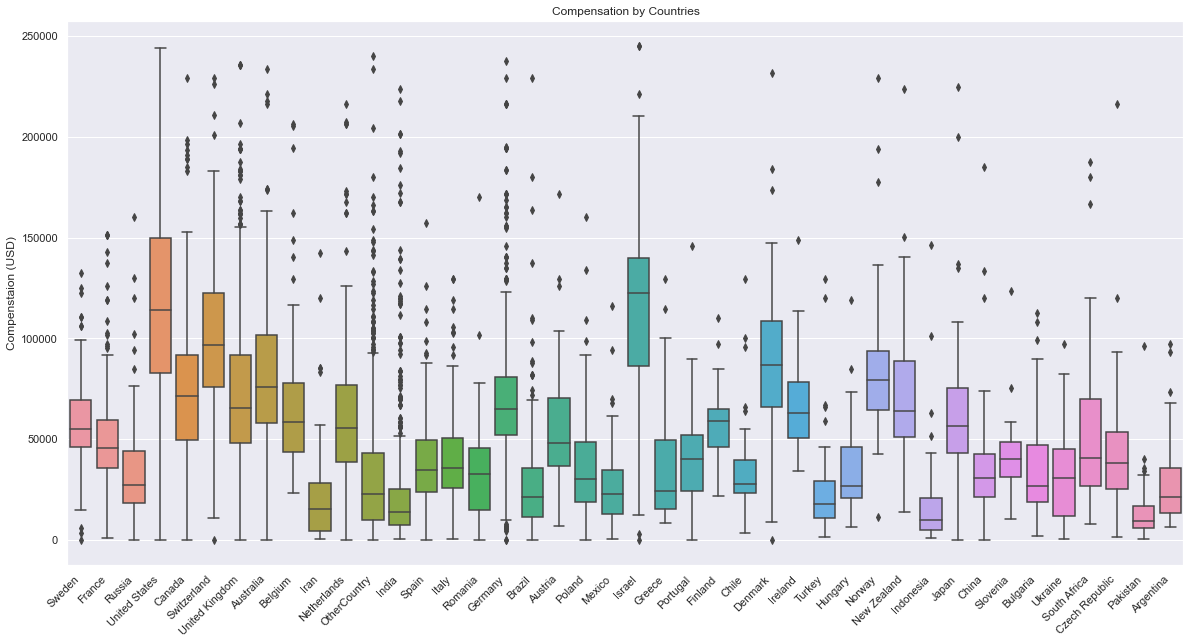

In [145]:
# EDA - Distribution of Employment Type and Compensation By Countries
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(y='ConvertedCompYearly', x='Country', 
                 data=master_clean 
                 #palette="colorblind",
                 #hue='Employment'
           )
plt.title('Compensation by Countries')
plt.ylabel('Compenstaion (USD)')
plt.xlabel('')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

**Comment:**
- The Boxplot of compensation by countries show that US and Israel have higher salary than the other countries with average values above \$110K
- Developed EU countries mostly have average salary between \\$50K and \\$100K
- Countries having less than 30 records were grouped in the `OtherCountry` group, and mostly they have low salary with average about \$25K 

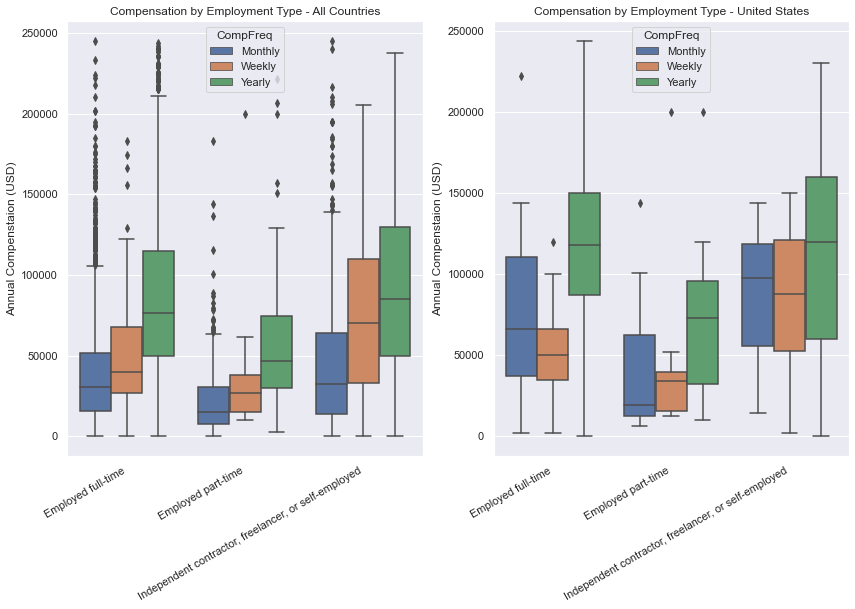

In [157]:
## EDA - Distribution of Employment Type and Compensation 
# Compensation by Reported CompFreq types
sort_data = master_clean.sort_values(['Employment', 'CompFreq'])
usa_master = sort_data[sort_data['Country']=='United States']

# All Countries
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
plt.subplot(1, 2, 1)
ax[0] = sns.boxplot(y='ConvertedCompYearly', x='Employment', 
                 data=sort_data, 
                 #palette="colorblind",
                 hue='CompFreq'
           )
ax[0].set_title('Compensation by Employment Type - All Countries')
ax[0].set_ylabel('Annual Compenstaion (USD)')
ax[0].set_xlabel('')
plt.setp(ax[0].get_xticklabels(), rotation=30, ha='right')

# United States
plt.subplot(1, 2, 2)
ax[1] = sns.boxplot(y='ConvertedCompYearly', x='Employment', 
                 data=usa_master, 
                 #palette="colorblind",
                 hue='CompFreq'
           )
ax[1].set_title('Compensation by Employment Type - United States')
ax[1].set_ylabel('Annual Compenstaion (USD)')
ax[1].set_xlabel('')
plt.setp(ax[1].get_xticklabels(), rotation=30, ha='right')

plt.show()

In [156]:
master_clean.Employment.value_counts()

Employed full-time                                      7185
Independent contractor, freelancer, or self-employed     729
Employed part-time                                       417
Name: Employment, dtype: int64

In [158]:
master_clean.CompFreq.value_counts()

Yearly     5003
Monthly    3136
Weekly      192
Name: CompFreq, dtype: int64

**Comment:**
- Most records are employed full-time position (86%). A small portion in the dataset (5%) is employed part-time.
- We could also see from the boxplot of compensation by employment type that salary is not much different between full-time and independent contractor. Employed part-time earn less than full-time position about a-half, but we're missing the information of how-many hours per week that a person works.
- The salary surveys allow people to report their compensation by either in weekly, monthly or yearly in the `CompFreq` variable, and then converted all the records to yearly compensation in USD in the `ConvertedCompYearly` variable. We could see that people reported their salary in yearly have higher annual compensation than people reported in weekly and monthly. This is unsual and could impact our models perfomance. Therefore, I included the `CompFreq` in our model data to handle how people reported their salary. The difference between yearly and weekly/ monthly could be because people also include bonus in their yearly compensation, and possibly that people reported gross amount in yearly versus net amount in weekly & monthly, or could be wrong input especially for the outliers data (i.e. above \\$250K or below \\$10K for US, etc). 

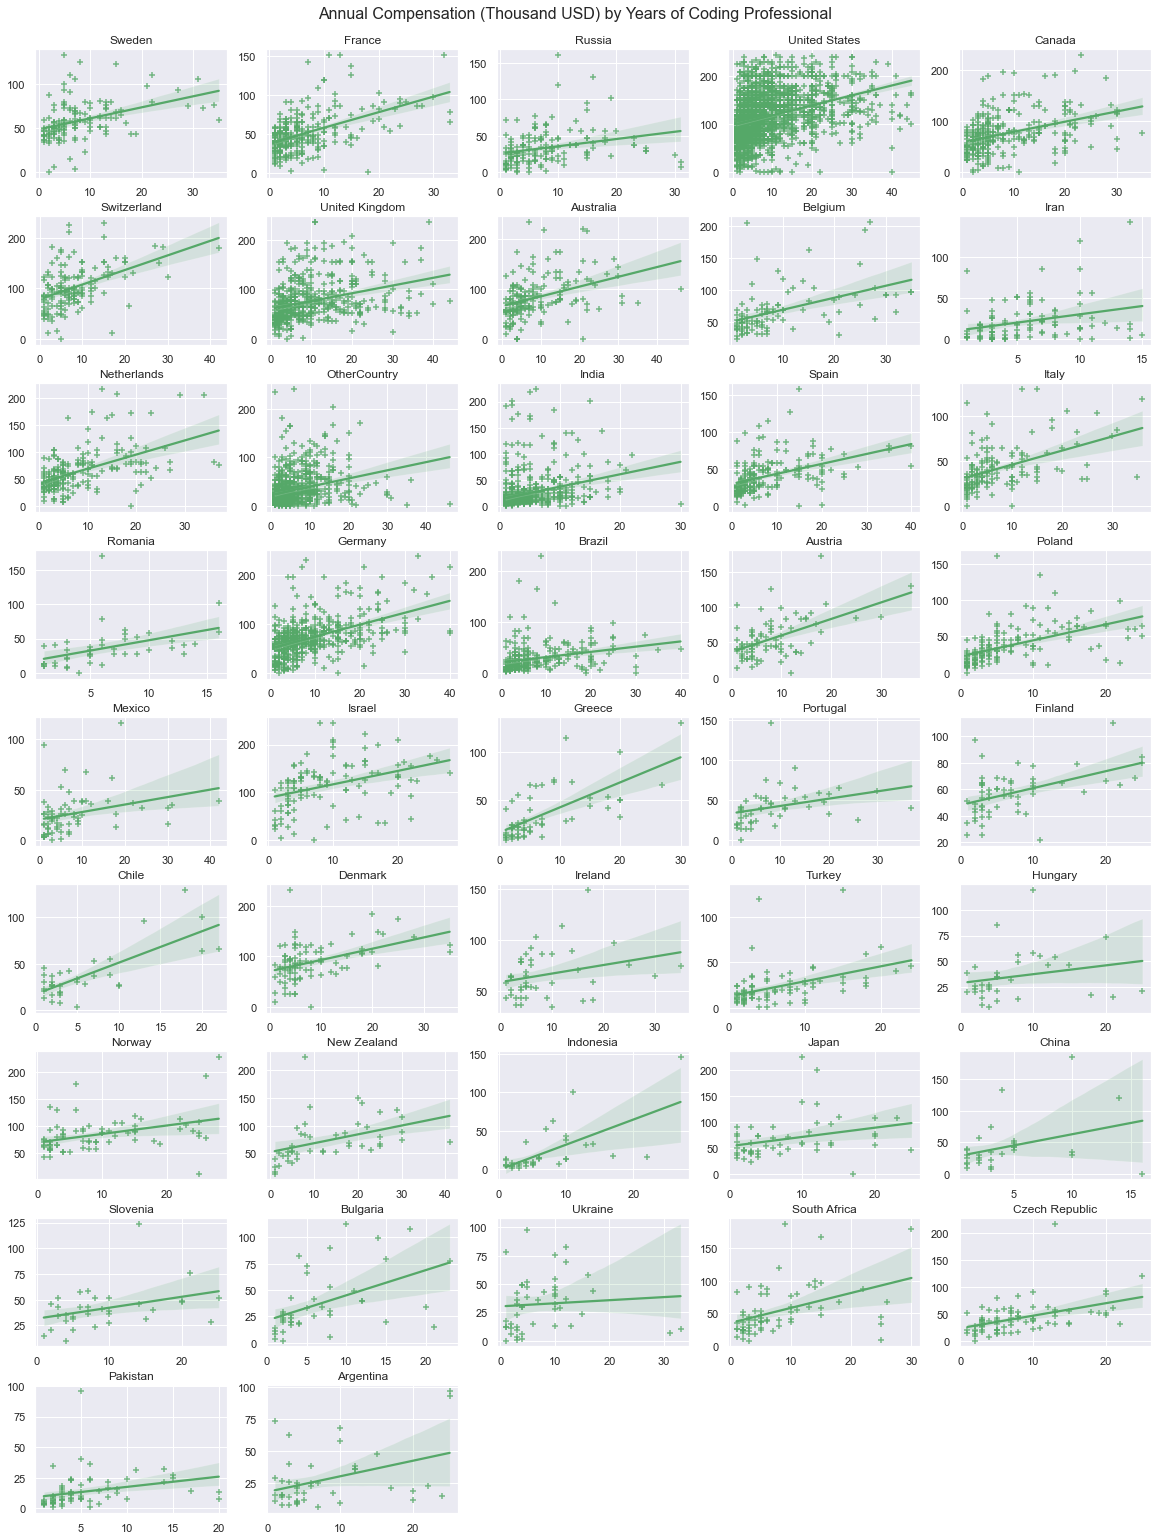

In [14]:
# EDA Compensation by Years of Coding Professional by Countries
fig = plt.figure(figsize=(20,30))
plt.suptitle('Annual Compensation (Thousand USD) by Years of Coding Professional', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
i = 1
for idx, label in enumerate(master_clean.Country.unique()):
    plt.subplot(10, 5, i)
    subset = master_clean[master_clean.Country == label]
    sns.regplot(y=subset.ConvertedCompYearly/1000, x=subset.YearsCodePro, color='g', marker='+')
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    i += 1

**Comment:**
- Positive correlation between the number of years of professional coding experienced with the compensation for all countries.
- US data is pretty noisy/ spread-out for compensation versus years of professional coding, especially for people having 1 - 10 years of experience, with annual salary reported ranging from \\$10K - \\$250K.  

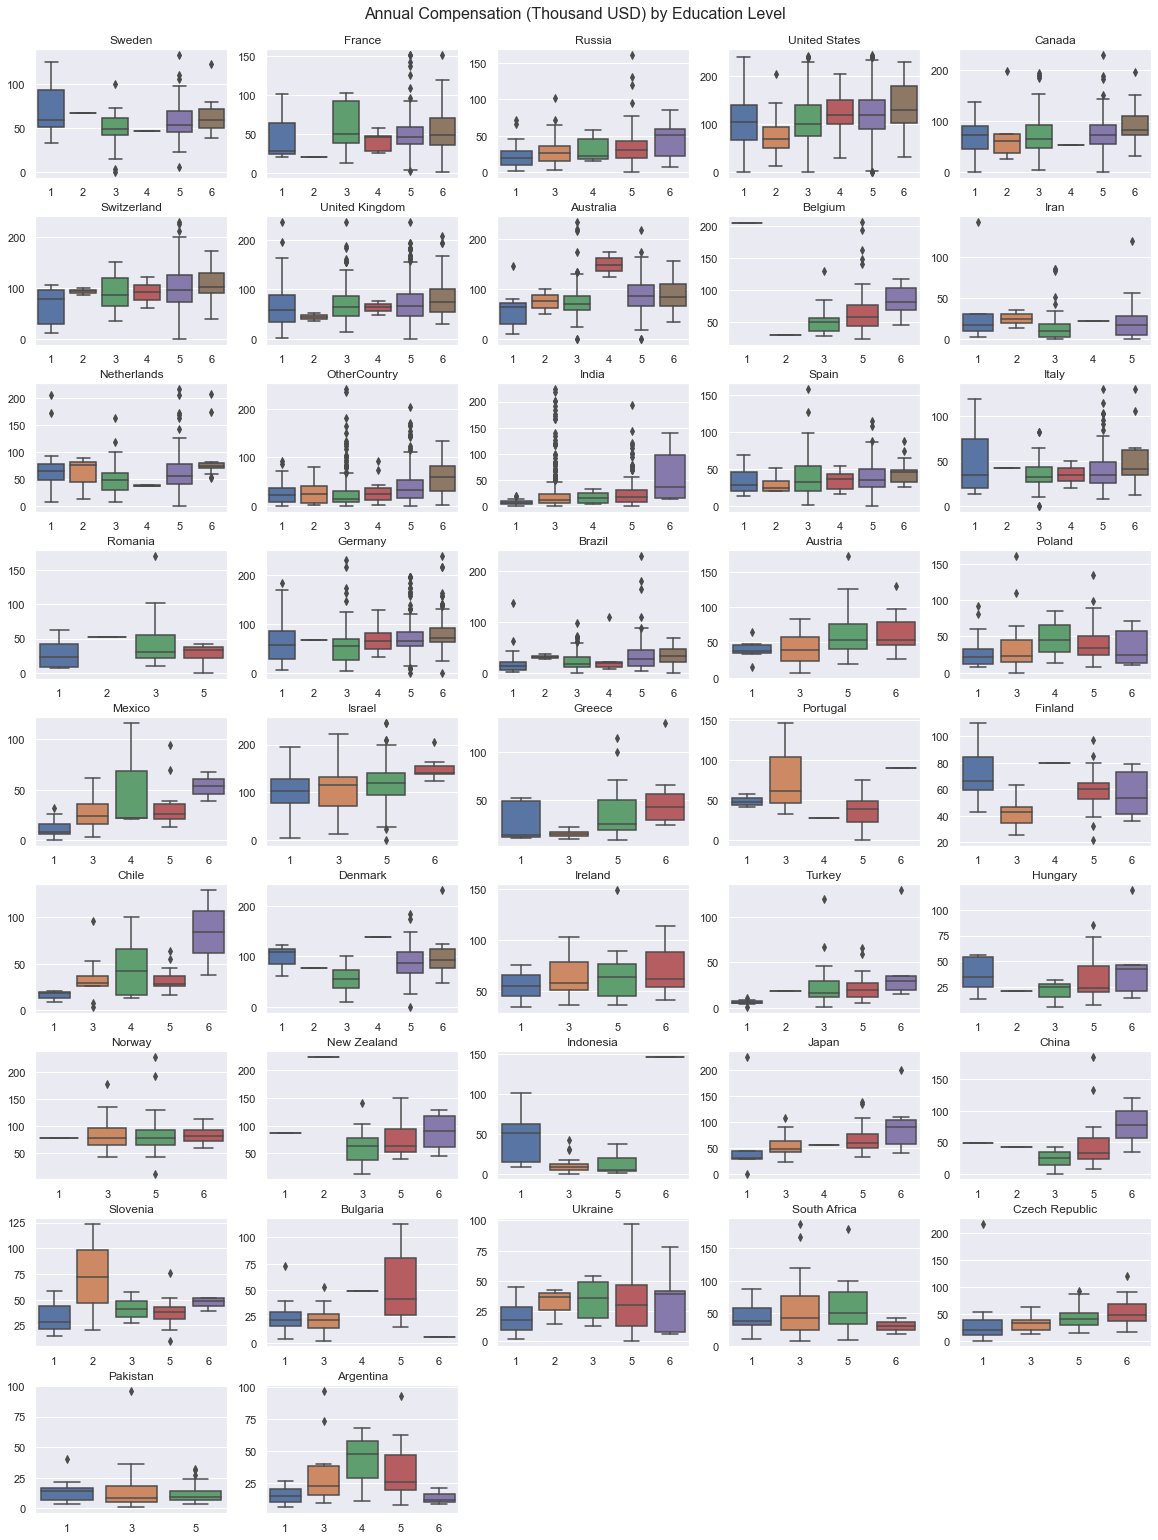

In [15]:
# EDA Compensation by Education Level by Countries
fig = plt.figure(figsize=(20,30))
plt.suptitle('Annual Compensation (Thousand USD) by Education Level', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
i = 1
for idx, label in enumerate(master_clean.Country.unique()):
    plt.subplot(10, 5, i)
    subset = master_clean[master_clean.Country == label]
    sns.boxplot(y=subset.ConvertedCompYearly/1000, x=subset.ed_ordinal)
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    i += 1

## Reference:    
# 1 - less than college
# 2 - Associate degree
# 3 - Bachelor degree
# 4 - Professional degree
# 5 - Master degree
# 6 - Doctor & up

**Comment:**
- Mostly positive correlation between education level and the compensation for all countries.

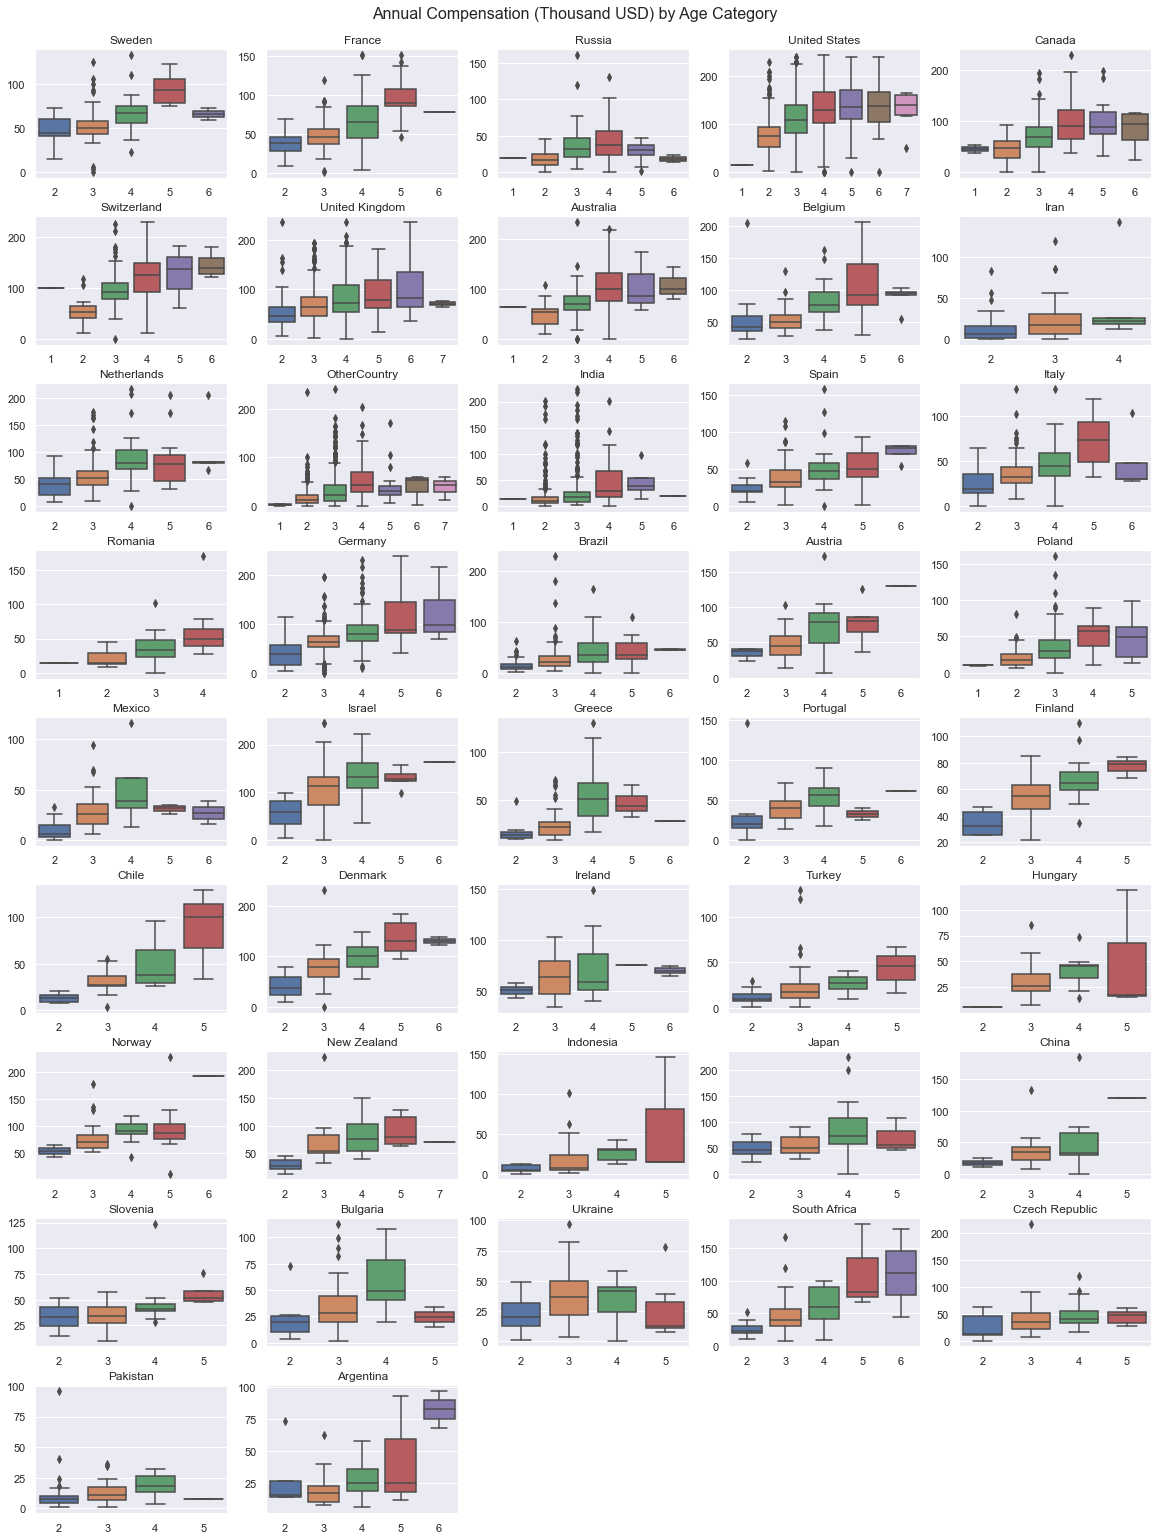

In [16]:
# EDA Compensation by Age By Countries
fig = plt.figure(figsize=(20,30))
plt.suptitle('Annual Compensation (Thousand USD) by Age Category', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
i = 1
for idx, label in enumerate(master_clean.Country.unique()):
    plt.subplot(10, 5, i)
    subset = master_clean[master_clean.Country == label]
    #sns.regplot(y=subset.ConvertedCompYearly/1000, x=subset.Age, color='g', marker='+')
    sns.boxplot(y=subset.ConvertedCompYearly/1000, x=subset.Age)
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    i += 1

## Reference:    
# 1 - < 18 years old
# 2 - 18-24 years old
# 3 - 25-34 years old
# 4 - 35-44 years old
# 5 - 45-54 years old
# 6 - 55-64 years old
# 7 - >= 65 years old

**Comment:**
- Positive correlation between age and the compensation for all countries.

Summary of Ethnicity after grouping:
white       5218
asian       1155
hispanic    1103
biracial     448
mideast      284
black        123
Name: Ethnicity_summary, dtype: int64


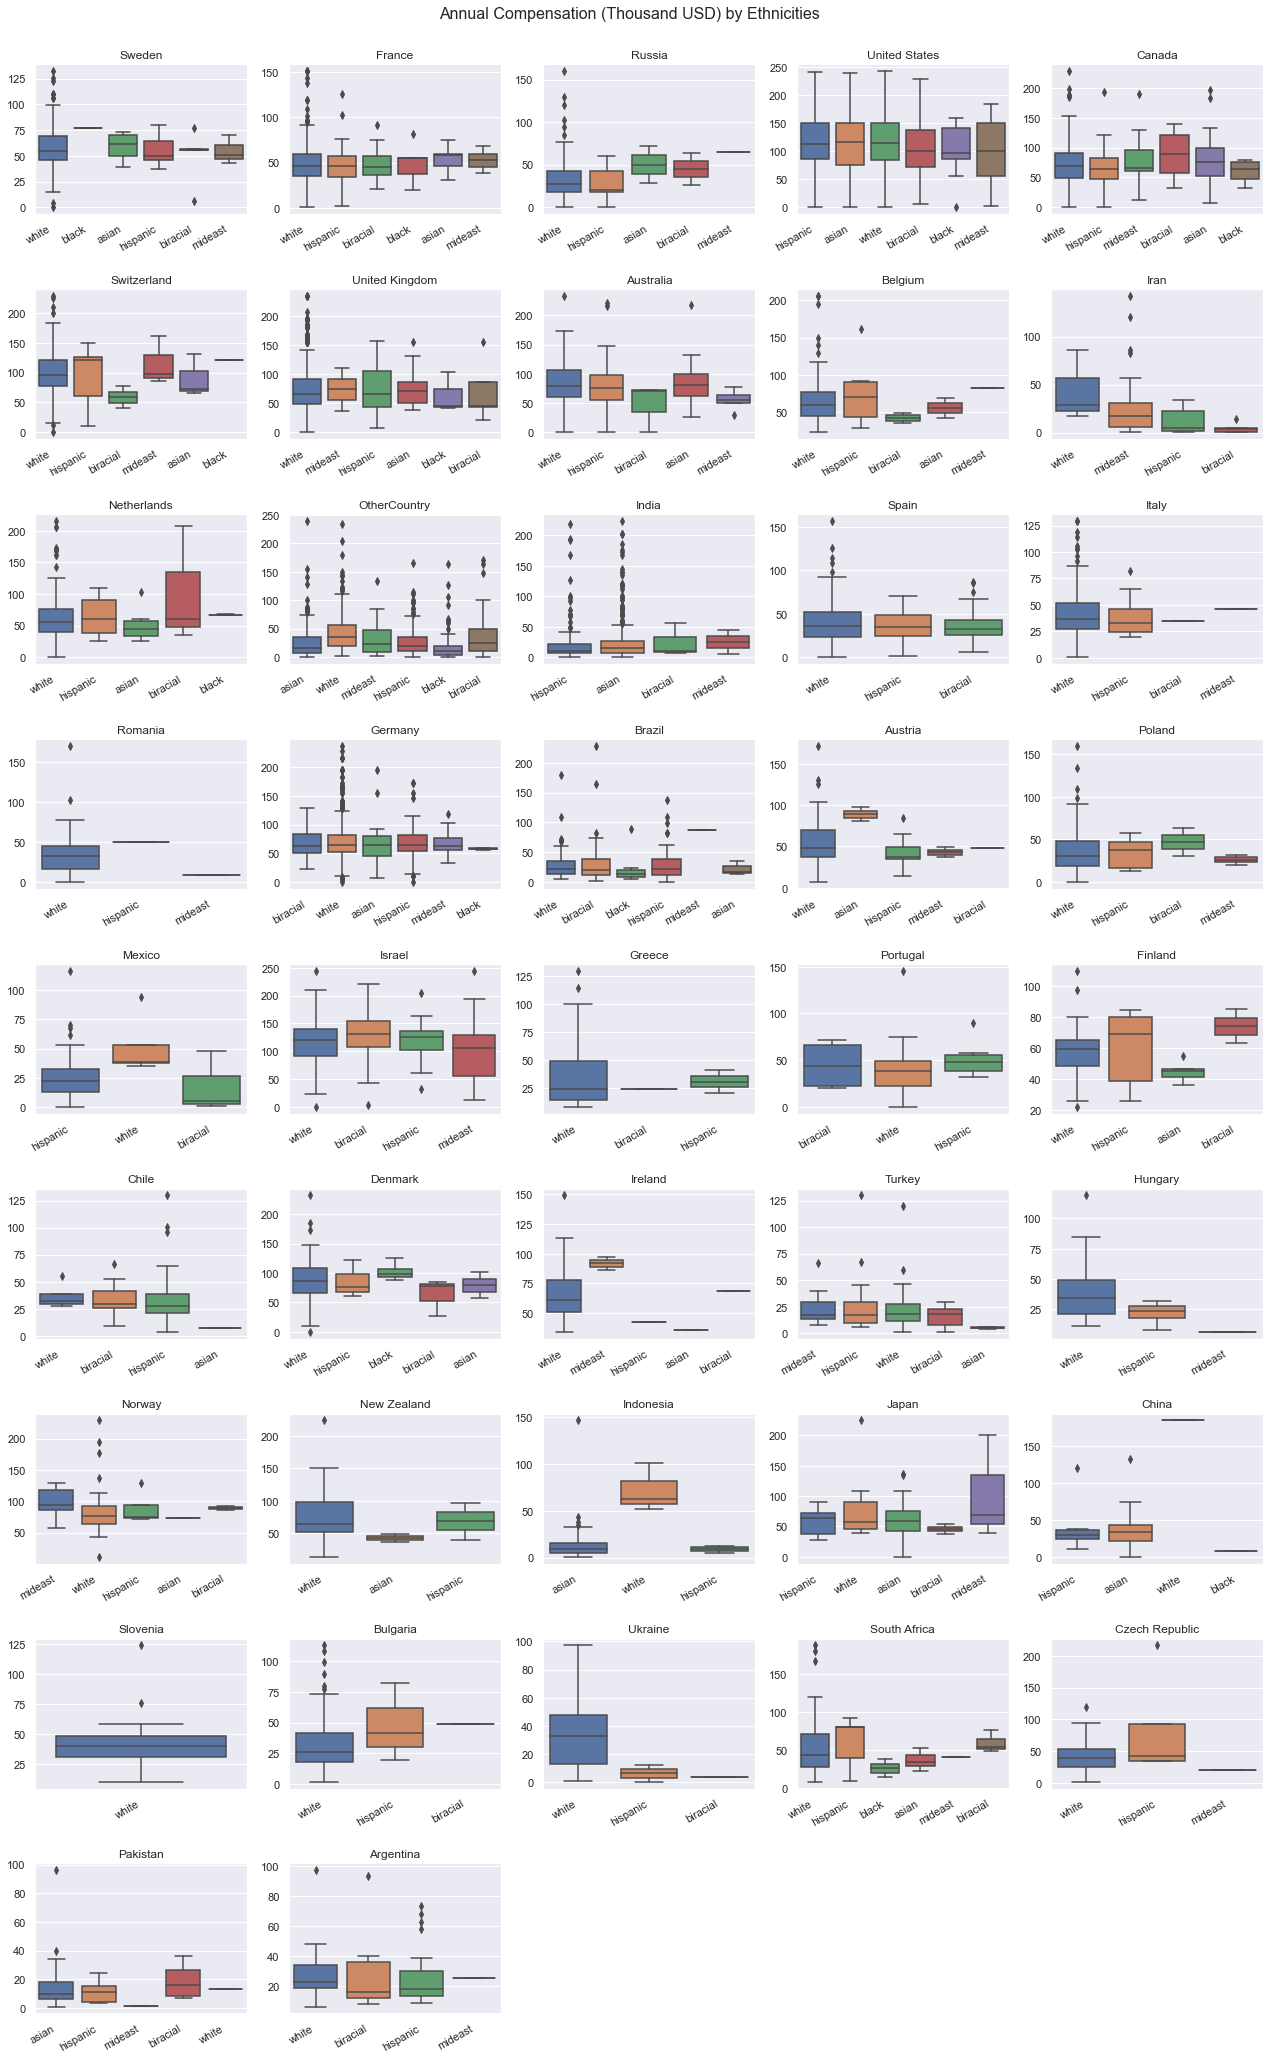

In [17]:
# EDA Compensation by Ethnicity by Countries
def ethnicity_summary(data):
    df = data.copy()
    df['Ethnicity_summary'] = np.where(df.white + df.asian + df.black + df.mideast + df.hispanic > 1, 'biracial',
                                       np.where(df.white == 1, 'white',
                                               np.where(df.asian == 1, 'asian',
                                                       np.where(df.black == 1,'black',
                                                               np.where(df.mideast == 1, 'mideast','hispanic')))))
    return df

master_clean_ethnicity = ethnicity_summary(master_clean)
print('Summary of Ethnicity after grouping:')
print(master_clean_ethnicity.Ethnicity_summary.value_counts())

# Plotting
fig = plt.figure(figsize=(22,40))
plt.suptitle('Annual Compensation (Thousand USD) by Ethnicities', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.5, wspace=0.2)
i = 1
for idx, label in enumerate(master_clean_ethnicity.Country.unique()):
    plt.subplot(10, 5, i)
    subset = master_clean_ethnicity[master_clean_ethnicity.Country == label]
    ax = sns.boxplot(y=subset.ConvertedCompYearly/1000, x=subset.Ethnicity_summary)
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    i += 1


**Comment:**
- The compensation is mostly not much different between different ethnicities for most countries. 

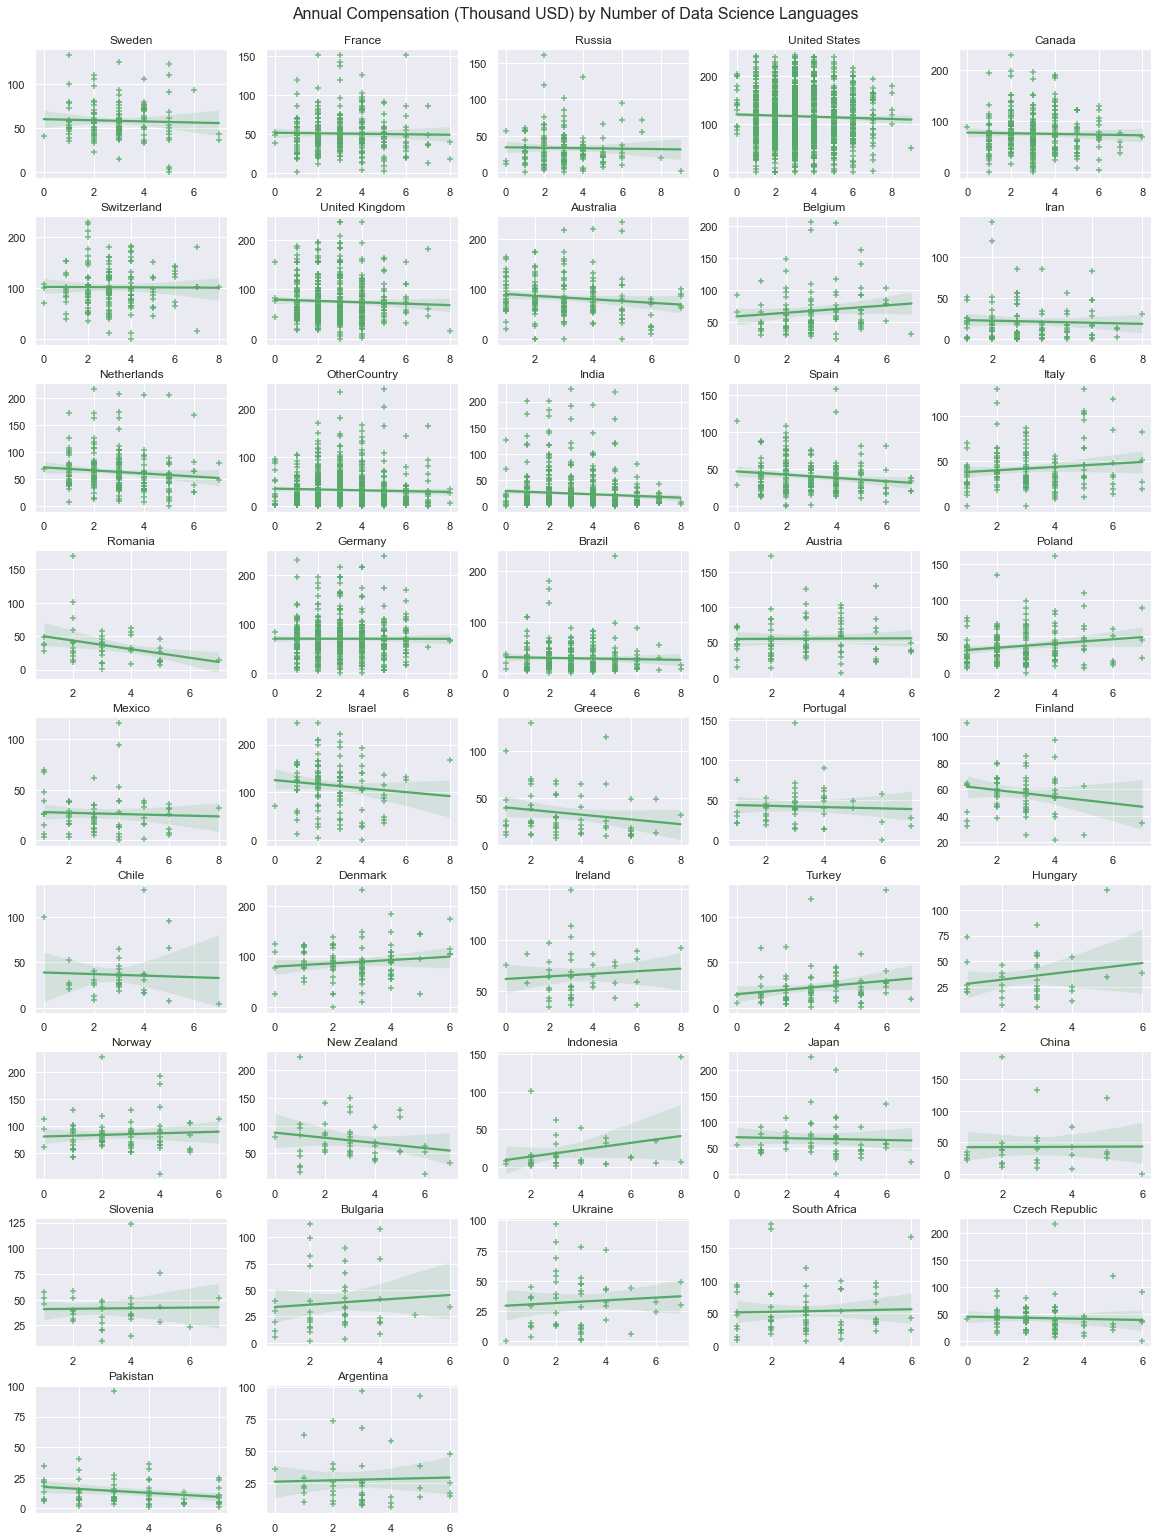

In [159]:
# EDA Compensation by Number of Data Science Languages by Countries
fig = plt.figure(figsize=(20,30))
plt.suptitle('Annual Compensation (Thousand USD) by Number of Data Science Languages', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
i = 1
for idx, label in enumerate(master_clean.Country.unique()):
    plt.subplot(10, 5, i)
    subset = master_clean[master_clean.Country == label]
    sns.regplot(y=subset.ConvertedCompYearly/1000, x=subset.language_DS, color='g', marker='+')
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    i += 1
    
## Reference - top 10 most common languages for data scientist
# Define a language as Data Science language when they are in the following group
# 'C', 'C++', 'Java', 'JavaScript', 'Julia', 'Matlab','Python', 'R', 'SQL'

**Comment:**
- There is no strong correlation or relationship between compensation and the number of data science language that a person has for most countries.
- Most people knows 1-5 different languages

#### 4.2. Skills Distribution

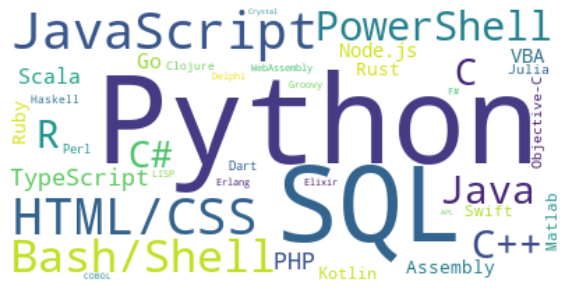

In [160]:
# Show the word cloud of LanguageHaveWorkedWith   
show_texts('LanguageHaveWorkedWith', master_clean)

In [161]:
# Show top 10 Language & their counts 
show_distribution('LanguageHaveWorkedWith', master_clean).head(10)

language_names counts
0         Python   7044
1            SQL   4895
2     JavaScript   4038
3       HTML/CSS   3764
4     Bash/Shell   3619
5     PowerShell   2959
6           Java   2587
7              R   2482
8            C++   2362
9              C   1738

**Comment:**
- The most common languages are Python & SQL
- I've grouped the languages as following and returned the total number of languages a person knows in each group:
    - Data Science Languages: 'C', 'C++', 'Java', 'JavaScript', 'Julia', 'Matlab','Python', 'R', 'SQL'
    - Command Line: 'Bash/Shell', 'PowerShell'
    - Web Development: 'HTML/CSS', 'PHP', 'Node.js','.NET'

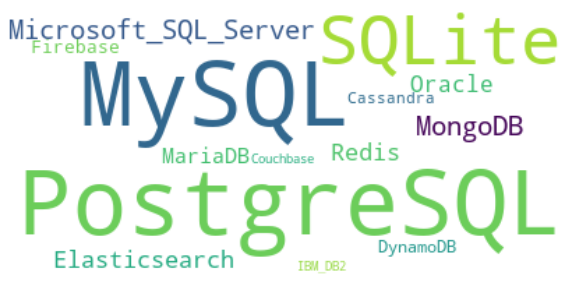

In [162]:
# Show the word cloud of DatabaseHaveWorkedWith  
show_texts('DatabaseHaveWorkedWith', master_clean)

In [163]:
# Show top 10 DataBase & their counts 
show_distribution('DatabaseHaveWorkedWith', master_clean).head(10)

language_names counts
0            PostgreSQL   3579
1                 MySQL   3494
2                SQLite   2757
3  Microsoft_SQL_Server   2210
4               MongoDB   2129
5                 Redis   1465
6         Elasticsearch   1433
7                Oracle   1197
8               MariaDB   1063
9              Firebase    680

**Comment:**
- The most common database that people have worked with are PostgreSQL and MySQL
- We've grouped the database as following:
    - SQL Database: 'IBM_DB2', 'MariaDB', 'Microsoft_SQL_Server', 'MySQL', 'Oracle', 'PostgreSQL', 'SQLite'
    - NoSQL Database: 'Cassandra', 'Couchbase', 'DynamoDB', 'Elasticsearch', 'Firebase', 'MongoDB', 'Redis'
- More people have SQL Dabatase skills than NoSQL Database skills

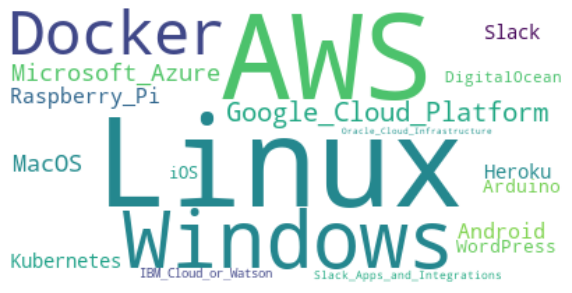

In [164]:
# Show the word cloud of PlatformHaveWorkedWith  
show_texts('PlatformHaveWorkedWith', master_clean)

In [165]:
# Show top 10 Platform & their counts 
show_distribution('PlatformHaveWorkedWith', master_clean).head(10)

language_names counts
0                  Linux   3774
1                    AWS   3200
2                Windows   2662
3                 Docker   2372
4  Google_Cloud_Platform   1926
5        Microsoft_Azure   1471
6                  MacOS   1433
7           Raspberry_Pi   1011
8                Android    978
9                  Slack    856

**Comment:**
- The most common platform that people have worked with are AWS and Docker (excluding OS platform)
- We've grouped the platform as following:
    - Cloud computing: 'AWS', 'DigitalOcean', 'Google_Cloud_Platform', 'Heroku', 'IBM_Cloud_or_Watson', 'Microsoft_Azure', 'Oracle_Cloud_Infrastructure'
    - Electronic platform: 'Arduino', 'Raspberry_Pi'
    - Container platform: 'Docker', 'Kubernetes'

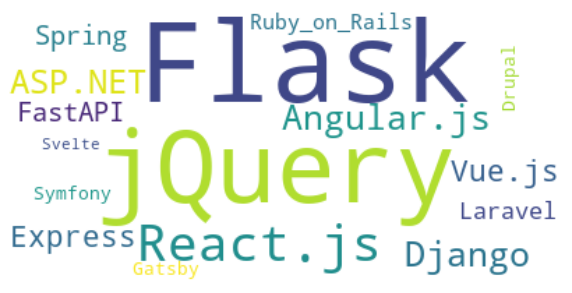

In [166]:
# Show the word cloud of WebframeHaveWorkedWith 
show_texts('WebframeHaveWorkedWith', master_clean)

In [167]:
# Show top 10 WebFrame & their counts 
show_distribution('WebframeHaveWorkedWith', master_clean).head(10)

language_names counts
0          Flask   1482
1         jQuery    960
2       React.js    942
3         Django    874
4     Angular.js    682
5        ASP.NET    517
6        Express    476
7         Vue.js    473
8         Spring    353
9        FastAPI    324

**Comment:**
- The most common web framework that people have worked with are Flask
- All of the above tools were grouped in the total number of web frameworks a person knows. 

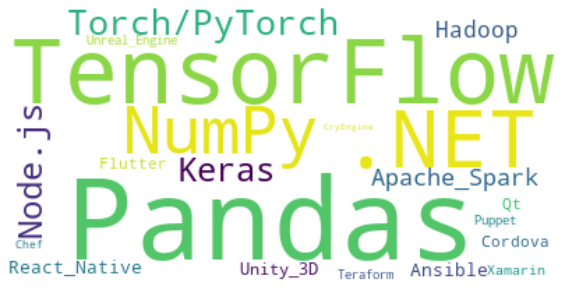

In [168]:
# Show the word cloud of MiscTechHaveWorkedWith
show_texts('MiscTechHaveWorkedWith', master_clean)

In [169]:
# Show top 10 MiscTech & their counts 
show_distribution('MiscTechHaveWorkedWith', master_clean).head(10)

language_names counts
0         Pandas   4798
1     TensorFlow   3401
2          NumPy   2004
3  Torch/PyTorch   1868
4          Keras   1570
5        Node.js   1486
6           .NET   1448
7   Apache_Spark   1402
8         Hadoop   1042
9   React_Native    453

**Comment:**
- The most common other tools that people have worked with are Pandas and TensorFlow
- We've grouped the above tools as following:
    - Machine Learning tools: 'Apache_Spark', 'Keras','TensorFlow', 'Torch/PyTorch'
    - App & UI development tools: 'Dart', 'Ansible', 'Cordova', 'CryEngine', 'Flutter', 'Qt', 'React_Native', 'Unity_3D', 'Unreal_Engine', 'Xamarin'
    - Server & distribution configuration tools: 'Chef', 'Hadoop', 'Puppet', 'Teraform'

#### 4.3.  Compensation and Primary Features Distribution

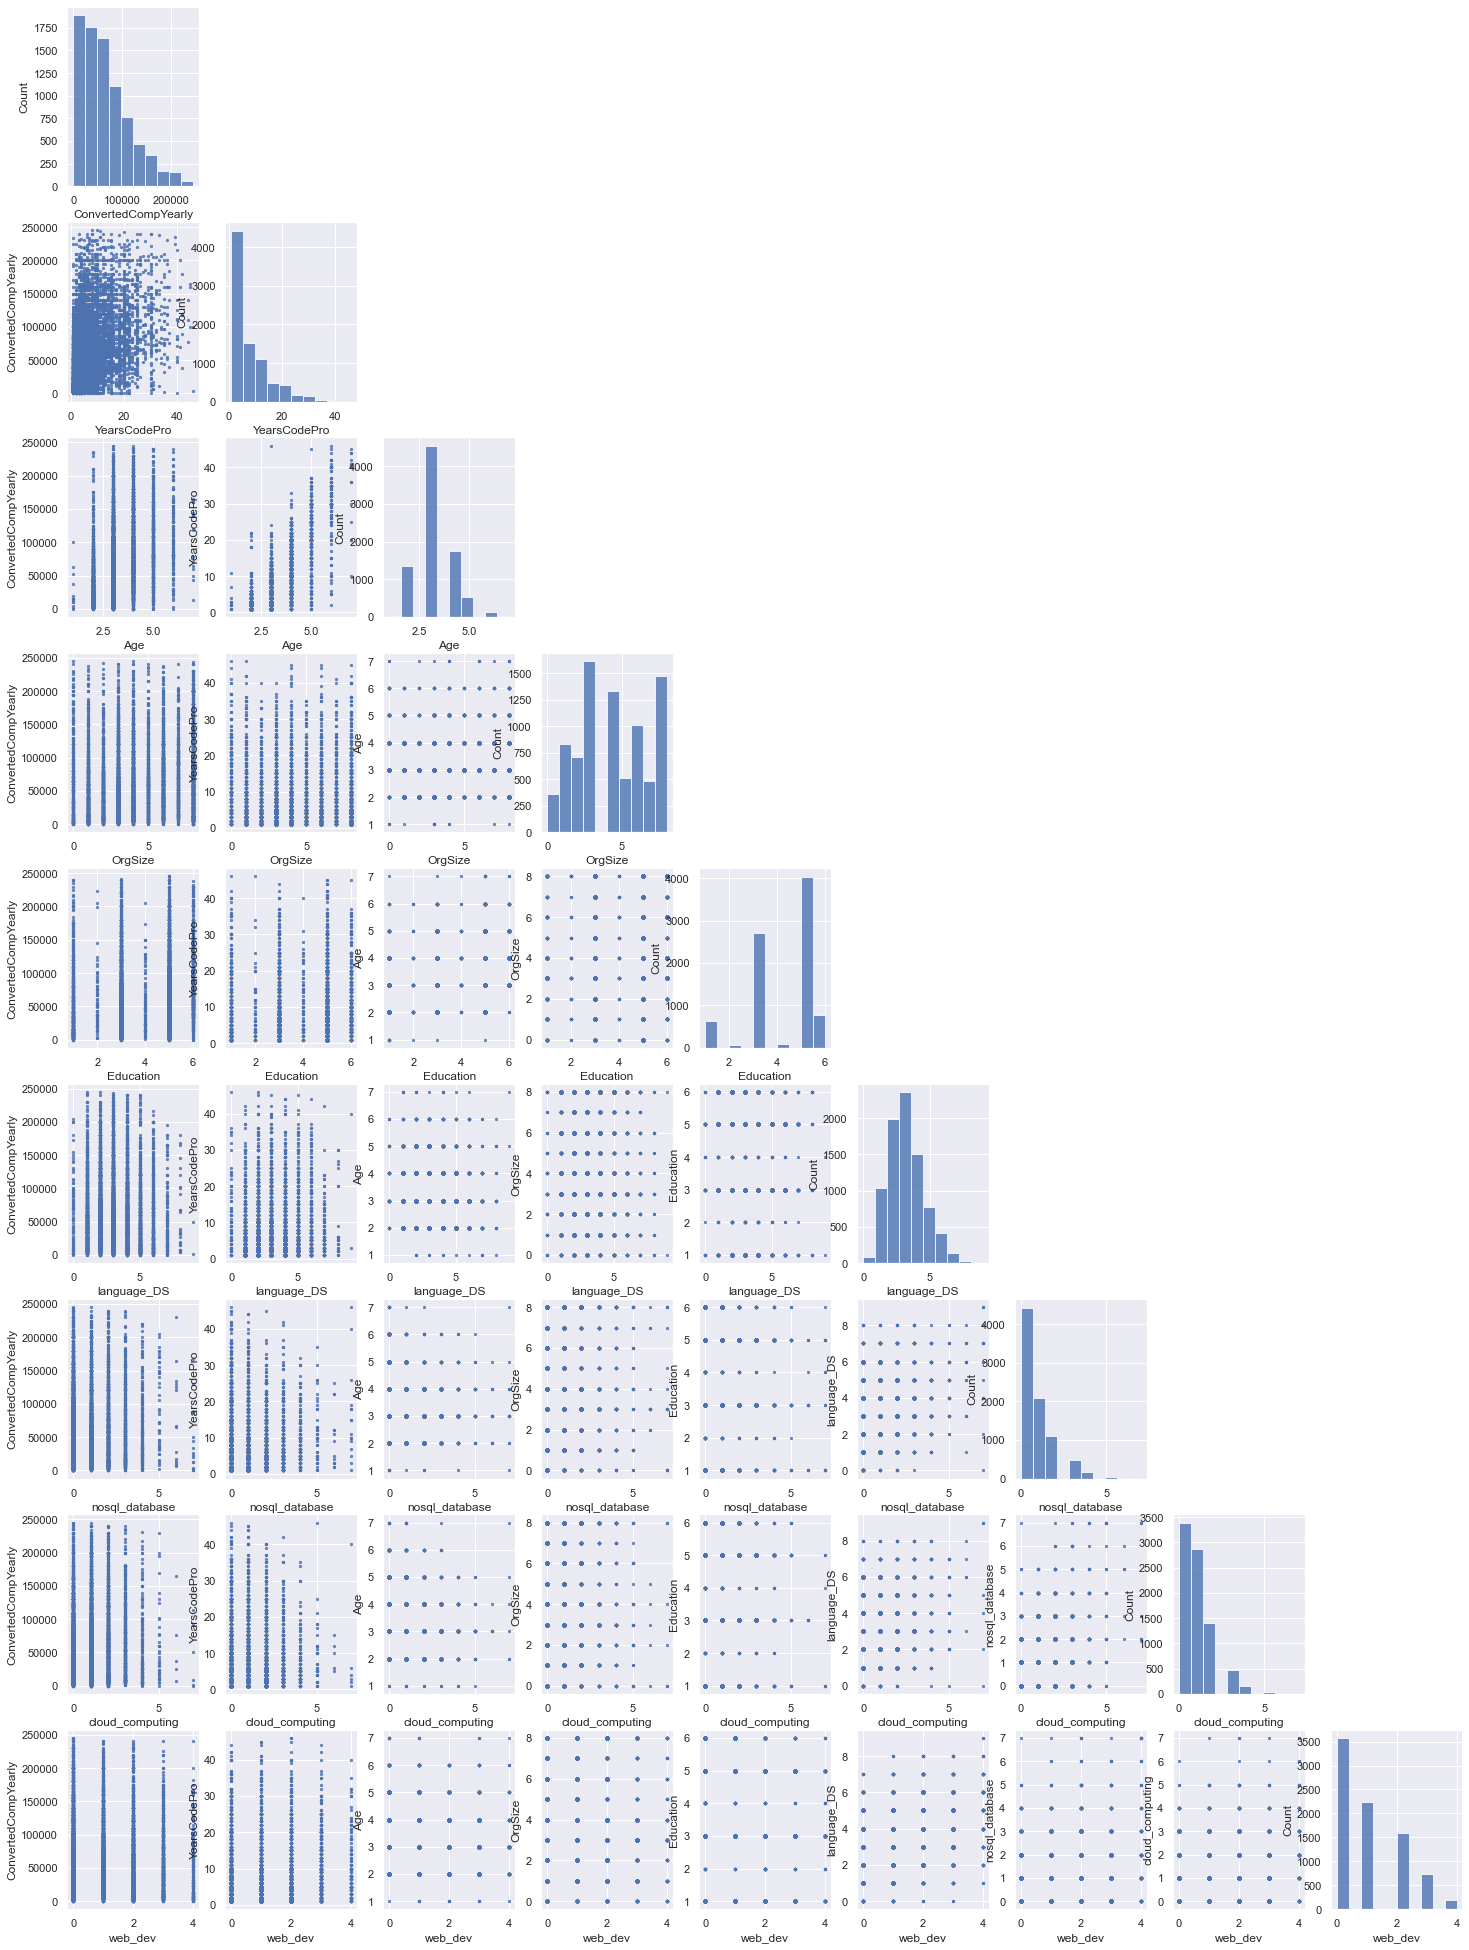

In [183]:
# Correlation of some variables - All Countries
df = master_clean.copy()
df['Log_Compensation'] = np.log(df['ConvertedCompYearly'])
df.rename(columns = {'ed_ordinal':'Education'}, inplace = True)
features = ['ConvertedCompYearly','YearsCodePro','Age','OrgSize','Education','language_DS','nosql_database','cloud_computing','web_dev']
scatterplotmatrix(df[features].values, names=features, figsize=(25,35), alpha=0.8, s=5);

**Comment:**
- The distribution for compensation value is right skew, most of the data are below \\$100K, much fewer records are above \\$150K, The imbalance in the data could negatively impact the performance of our models, and could be harder to predict salary at the higher range (above $150K for the continuous target as well as the upper range for the categorical target)
- More than 50\% people have less than 5 years of professional coding.
- More than 50\% people have master degree (Education=5).
- The average age is around 25-34 years old (age=3)
- The average number of data science languages that a person has is 3 languages.
- There is no strong correlation between compensation and the features above, and they look quite linear. The spread out of compensation accross the values of the listed features could indicate a challenging task in predicting the compensation range.  

### Step 5: Model data
#### 5.1. All countries data 

In [195]:
# Define Features Matrix for all countries
X = pd.concat((master_clean.iloc[:,[1,7,9,13]], master_clean.iloc[:,24:]), axis=1)
print('Feature Dimension:', X.values.shape)
X.head()

Feature Dimension: (8331, 75)


OrgSize  Age1stCode  YearsCodePro  Age  language_DS  language_others  \
0        2           2             4    3            2                0   
1        2           2             2    3            2                0   
2        3           2             3    3            3                0   
3        8           2             5    3            3                2   
4        5           1             8    4            2                0   

   command_line  web_dev  sql_database  nosql_database  cloud_computing  \
0             0        0             1               0                0   
1             0        0             1               0                0   
2             1        1             1               0                1   
3             1        2             3               0                3   
4             0        1             0               1                1   

   elec_platform  container_platform  web_framework  ML_tools  app_UI_dev  \
0              0                   0              0         3           0   
1              0                   0              0         4           0   
2              0                   0              3         1           0   
3              0                   0              1         0           0   
4              0                   0              1         3           0   

   server_dist_config  man  woman  sexualitycat  transbin  ed_ordinal  employ  \
0                   0    1      0             0         0           5       1   
1                   0    1      0             1         0           5       1   
2                   0    1      0             0         0           4       1   
3                   0    1      0             0         0           3       1   
4                   0    1      0             0         0           6       1   

   employ_parttime  white  asian  black  mideast  hispanic  biracial  2020  \
0                0      1      0      0        0         0         0     0   
1                0      1      0      0        0         0         0     0   
2                0      1      0      0        0         0         0     0   
3                0      0      0      0        0         0         0     0   
4                0      1      0      0        0         0         0     0   

   2021  Argentina  Australia  Austria  Belgium  Brazil  Bulgaria  Canada  \
0     1          0          0        0        0       0         0       0   
1     1          0          0        0        0       0         0       0   
2     1          0          0        0        0       0         0       0   
3     1          0          0        0        0       0         0       0   
4     1          0          0        0        0       0         0       1   

   Chile  China  Czech Republic  Denmark  Finland  France  Germany  Greece  \
0      0      0               0        0        0       0        0       0   
1      0      0               0        0        0       1        0       0   
2      0      0               0        0        0       0        0       0   
3      0      0               0        0        0       0        0       0   
4      0      0               0        0        0       0        0       0   

   Hungary  India  Indonesia  Iran  Ireland  Israel  Italy  Japan  Mexico  \
0        0      0          0     0        0       0      0      0       0   
1        0      0          0     0        0       0      0      0       0   
2        0      0          0     0        0       0      0      0       0   
3        0      0          0     0        0       0      0      0       0   
4        0      0          0     0        0       0      0      0       0   

   Netherlands  New Zealand  Norway  Pakistan  Poland  Portugal  Romania  \
0            0            0       0         0       0         0        0   
1            0            0       0         0       0         0        0   
2            0            0       0         0       0      

In [196]:
# Define Target values and Target classification for all countries
y = master_clean[['ConvertedCompYearly','Comp_Bracket','Comp_Bracket_HML']]
print("Target dimension:", y.values.shape)
y.head()

Target dimension: (8331, 3)


ConvertedCompYearly  Comp_Bracket  Comp_Bracket_HML
0                51552             6                 2
1                38915             4                 2
2                22644             3                 1
3               130000            11                 3
4               151263            12                 3

<AxesSubplot:>

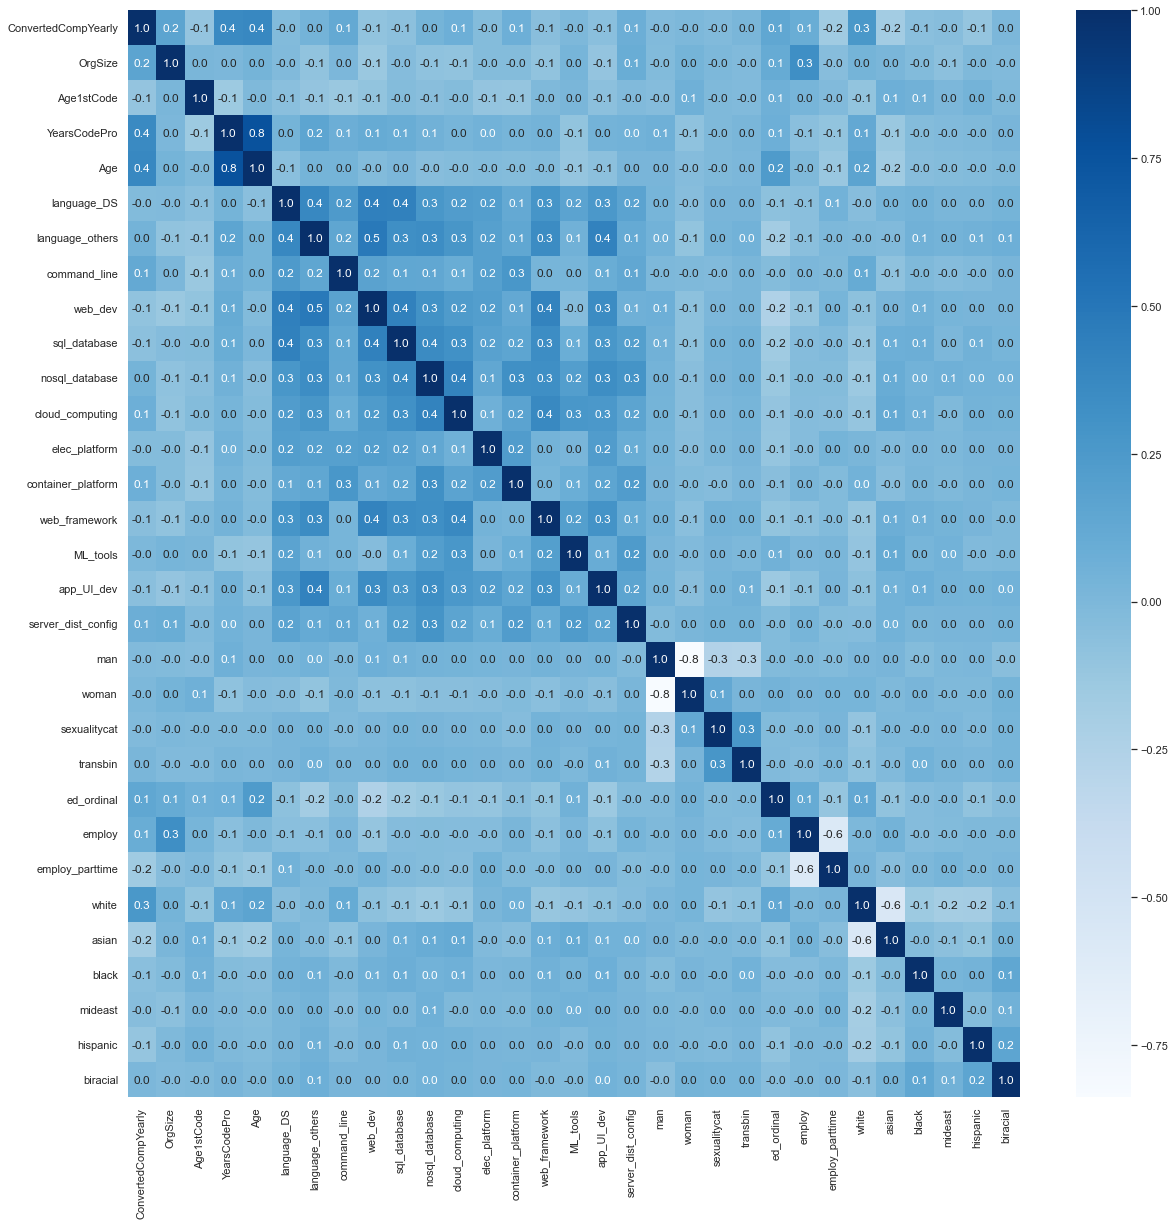

In [197]:
## Check Correlation Matrix of the Features and Target
corr_data = pd.concat((y.iloc[:,0], X.iloc[:,:30]), axis=1)
corr_matrix = corr_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.1f')
# Features with high correlation:
# 1. YearsCodePro and Age, corr=0.8
# 2. woman and man, corr=0.8
# 3. employ_parttime and employ_fulltime, corr=0.6
# 4. white and asian, corr=0.6

**Comment:**
- The correlation matrix between the target and the features (not including countries) shows that compensation does not have high correlation with any features in this dataset and mostly below 0.2. The best features that correlate with compensation are:
    - Number of years with professional coding experience, age: corr = 0.4
    - White people: corr=0.3
- There is no perfect colinearity between the features, the highest correlation between the features are as following. These are as expected:
    - Number of years with professional coding and Age, corr=0.8
    - Employ parttime and employ fulltime, corr=0.6
    - White and asian, corr=0.6
 - I will use all of these features in our models, and will not drop any feature with high correlation with the others (i.e. keeping both years with professional coding and age) since the max correlation at 0.8 is not very high and is acceptable to use. 

In [208]:
# Split data to training set, development set and test set
# Split test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X.values,y.values,
                                                            test_size=0.15,
                                                            random_state=0)
                                                            #stratify=y.values[:,1])
# Split train and dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev,y_train_dev,
                                                            test_size=0.1765,
                                                            random_state=0)
                                                            #stratify=y_train_dev[:,1])

print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_dev.shape)
print('Development Label Dimension:', y_dev.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (5831, 75)
Train Label Dimension: (5831, 3)
Development Data Dimension: (1250, 75)
Development Label Dimension: (1250, 3)
Test Data Dimension: (1250, 75)
Test Label Dimension: (1250, 3)


In [36]:
# Standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_dev_std = sc.transform(X_dev)
X_test_std = sc.transform(X_test)

#### 5.2. US Only data 

In [113]:
# Define Features Matrix for just US Only
master_clean_US = master_clean.copy()
master_clean_US = master_clean_US[master_clean_US['Country'] == 'United States']
X_US = pd.concat((master_clean_US.iloc[:,[1,7,9,13]], master_clean_US.iloc[:,24:52]), axis=1)
print('Feature Dimension:', X_US.values.shape)
X_US.head()

Feature Dimension: (1971, 32)


OrgSize  Age1stCode  YearsCodePro  Age  language_DS  language_others  \
3         8           2             5    3            3                2   
5         3           2             1    3            3                1   
9         1           2             9    3            4                3   
19        8           0             6    4            2                0   
30        4           1            20    4            2                1   

    command_line  web_dev  sql_database  nosql_database  cloud_computing  \
3              1        2             3               0                3   
5              1        1             0               0                1   
9              0        0             1               2                1   
19             1        0             2               0                2   
30             1        2             2               0                1   

    elec_platform  container_platform  web_framework  ML_tools  app_UI_dev  \
3               0                   0              1         0           0   
5               0                   0              0         0           0   
9               0                   0              2         1           1   
19              0                   0              0         0           0   
30              0                   0              4         0           0   

    server_dist_config  man  woman  sexualitycat  transbin  ed_ordinal  \
3                    0    1      0             0         0           3   
5                    0    1      0             0         0           6   
9                    0    1      0             0         0           5   
19                   0    1      0             0         0           6   
30                   0    1      0             0         0           3   

    employ  employ_parttime  white  asian  black  mideast  hispanic  biracial  \
3        1                0      0      0      0        0         0         0   
5        1                0      0      1      0        0         0         0   
9        1                0      1      0      0        0         0         0   
19       1                0      1      0      0        0         0         0   
30       1                0      1      0      0        0         0         0   

    2020  2021  
3      0     1  
5      0     1  
9      0     1  
19     0     1  
30     0     1

In [114]:
# Define Target values and Target classification for just US Only
y_US = master_clean_US[['ConvertedCompYearly','Comp_Bracket','Comp_Bracket_HML']]
print("Target dimension:", y_US.values.shape)
y_US.head()

Target dimension: (1971, 3)


ConvertedCompYearly  Comp_Bracket  Comp_Bracket_HML
3                130000            11                 3
5                100000            10                 2
9                 70000             8                 2
19                90000             9                 2
30               130000            11                 3

In [192]:
# Split data to training set, development set and test set for just US Only
# Split test set
X_train_dev_US, X_test_US, y_train_dev_US, y_test_US = train_test_split(X_US.values, y_US.values,
                                                            test_size=0.15,
                                                            random_state=0)
# Split train and dev set
X_train_US, X_dev_US, y_train_US, y_dev_US = train_test_split(X_train_dev_US, y_train_dev_US,
                                                            test_size=0.1765,
                                                            random_state=0)

print('Train Data Dimension - US Only:', X_train_US.shape)
print('Train Label Dimension - US Only:', y_train_US.shape)
print('Development Data Dimension - US Only:', X_dev_US.shape)
print('Development Label Dimension - US Only:', y_dev_US.shape)
print('Test Data Dimension - US Only:', X_test_US.shape)
print('Test Label Dimension - US Only:', y_test_US.shape)

Train Data Dimension - US Only: (1379, 32)
Train Label Dimension - US Only: (1379, 3)
Development Data Dimension - US Only: (296, 32)
Development Label Dimension - US Only: (296, 3)
Test Data Dimension - US Only: (296, 32)
Test Label Dimension - US Only: (296, 3)


In [118]:
# Standardize the features for US Only
X_train_std_US = sc.fit_transform(X_train_US)
X_dev_std_US = sc.transform(X_dev_US)
X_test_std_US = sc.transform(X_test_US)

### Step 6: Model Training - Continuous Target
#### 6.1. Linear Regression

## Base Model - Linear Regression:

RMSE train: 31794.68
RMSE test: 30144.14

R2 Score train: 0.600
R2 Score test: 0.632

Adjusted R2 Score train: 0.595
Adjusted R2 Score test: 0.609


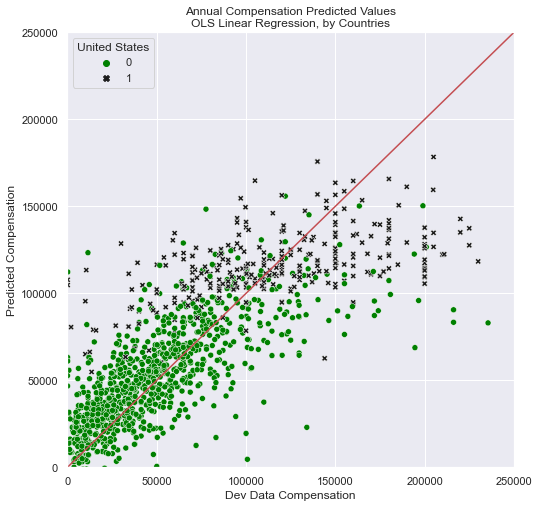

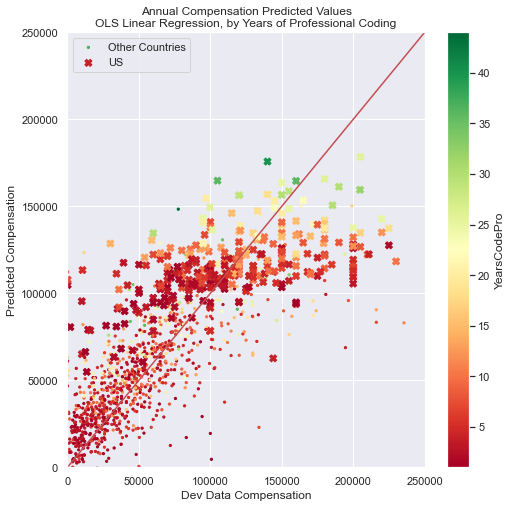

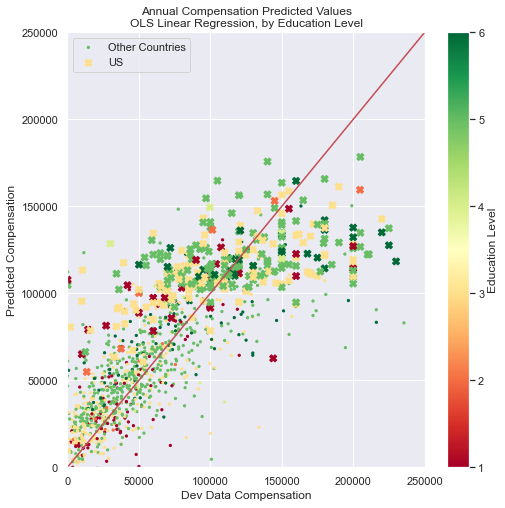

In [203]:
## Base Model - No transformation
# Base Model
lr = LinearRegression()
lr.fit(X_train, y_train[:,0])
y_train_pred = lr.predict(X_train)
y_dev_pred = lr.predict(X_dev)

# Function to print out Evaluation Result
def model_evaluation(X_train, y_train, y_train_pred, X_dev, y_dev, y_dev_pred):
    '''Display the evaluation result of the model'''
    # Root Mean Square Error
    # print('\nRMSE train: %.2f' %np.sqrt(mean_squared_error(np.log(y_train[:,0]), y_train_pred2)))
    print('\nRMSE train: %.2f' %np.sqrt(mean_squared_error(y_train[:,0], y_train_pred)))
    print('RMSE test: %.2f' %np.sqrt(mean_squared_error(y_dev[:,0], y_dev_pred)))

    # R-squared
    r2_train = r2_score(y_train[:,0], y_train_pred)
    r2_test = r2_score(y_dev[:,0], y_dev_pred)
    print('\nR2 Score train: %.3f' %r2_train)
    print('R2 Score test: %.3f' %r2_test)
    
    # Adjusted R-squared
    print('\nAdjusted R2 Score train: %.3f' %adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]))
    print('Adjusted R2 Score test: %.3f' %adjusted_r2(r2_test, X_dev.shape[0], X_dev.shape[1]))

# Function to calculate adjusted R-squared
def adjusted_r2(r2, n, p):
    '''Function to calculate adjusted r-squared from r-square, sample size and number of independent variables'''
    return 1-(1-r2)*(n-1)/(n-p-1)

# Function to plot predicted compensation and actual compensation
def plot_predictions(X_dev, y_dev, y_dev_pred, column_name, title):
    column_idx = X.columns.tolist().index(column_name)
    #fig = plt.figure(figsize=(8, 8))
    #ax = fig.add_subplot()
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if column_idx in range(17) or column_idx==21:
        # Subset data for US
        US = [i for i in range(X_dev.shape[0]) if X_dev[i,-3] == 1]
        Others = [i for i in range(X_dev.shape[0]) if X_dev[i,-3] == 0]
        # Plot Continuous & Ordinal Column 
        # Plot Other Countries
        plt.scatter(y_dev[Others], y_dev_pred[Others], c=X_dev[Others,column_idx], 
                cmap="RdYlGn", s=20, alpha=1, marker='.', label='Other Countries',
                vmin=X_dev[:,column_idx].min(), vmax=X_dev[:,column_idx].max())
        # Plot US
        plt.scatter(y_dev[US], y_dev_pred[US], c=X_dev[US,column_idx], 
                cmap="RdYlGn", s=50, alpha=1, marker='X', label='US', edgecolors=None,
                vmin=X_dev[:,column_idx].min(), vmax=X_dev[:,column_idx].max())
        ax.legend()
        cbar = plt.colorbar(ax=ax)
        if column_name == 'ed_ordinal':
            column_name = 'Education Level'
        cbar.set_label(column_name)
    else:
        # Plot binary Column
        sns.scatterplot(y_dev, y_dev_pred, hue=X_dev[:,column_idx], style=X_dev[:,column_idx],
                       palette=['green','k'])
        ax.legend(title=column_name)

        
    ax.set_title("Annual Compensation Predicted Values\n" + title)
    ax.set_ylabel("Predicted Compensation")
    ax.set_xlabel("Dev Data Compensation")
    ax.set_ylim(0,250000)
    ax.set_xlim(0,250000)
    ax.plot(np.linspace(0,250000, 5),np.linspace(0,250000, 5), '-r')

    plt.show()

print('## Base Model - Linear Regression:')
model_evaluation(X_train, y_train, y_train_pred, X_dev, y_dev, y_dev_pred)
plot_predictions(X_dev, y_dev[:,0], y_dev_pred, column_name='United States', 
                 title='OLS Linear Regression, by Countries')    
plot_predictions(X_dev, y_dev[:,0], y_dev_pred, column_name='YearsCodePro', 
                 title='OLS Linear Regression, by Years of Professional Coding')
plot_predictions(X_dev, y_dev[:,0], y_dev_pred, column_name='ed_ordinal', 
                 title='OLS Linear Regression, by Education Level')

**Comment:**
- The base model using OLS linear regression for all countries data with full features achieve R2 score at 0.632 and our prediction accuracy is $\pm$ 30,144.14 USD for RMSE. 
- From the predicted values versus development data plots, we could see that our base model mostly predicted values lower than the actual values when the compensation is above \\$150K. This could be due to lower sample count at the higher range and data imbalance. This could indicate that using log transform for the target value could be a candidate to help lessen the imbalance effect. We will therefore build a model with log transform in the following code block to evaluate.
- For US data, we could see that the base model over predicts when the salary is less than \\$100K, and under predicts when the salary is more than \\$150K. In this project, we will look at building models for US data only in the later part to evaluate their performances and if there is any advantages in focusing on US data separately. 
- Most data for salary above \\$150K belong to US, and we could see there is a weak relationship between the number years of professional coding and education level with salary using this model. 

## Linear Regression - Transform Compensation to Log scale Model:

RMSE train: 34173.49
RMSE test: 32153.94

R2 Score train: 0.528
R2 Score test: 0.495

Adjusted R2 Score train: 0.522
Adjusted R2 Score test: 0.463


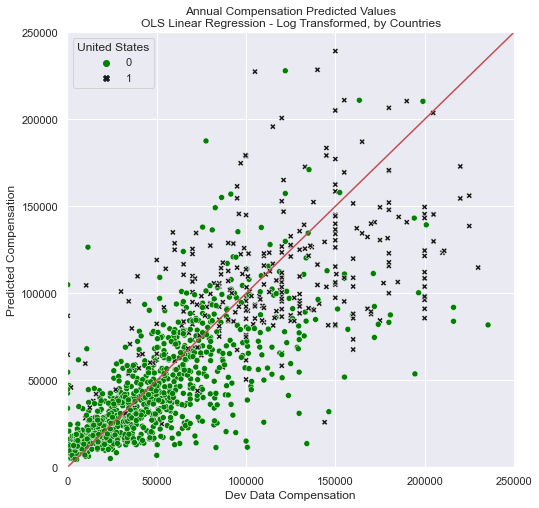

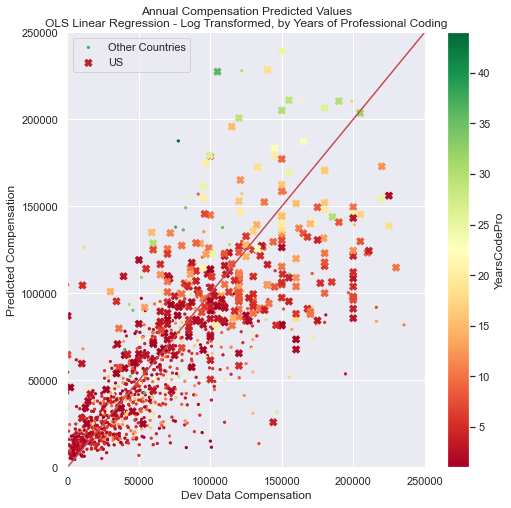

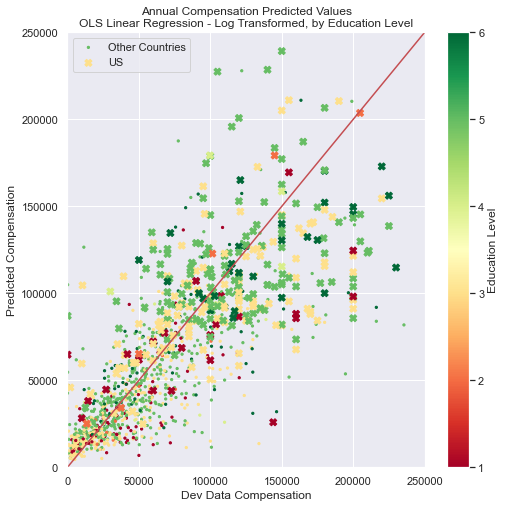

In [46]:
# Transform compensation to Log Scale
lr2 = LinearRegression()
lr2.fit(X_train, np.log(y_train[:,0]))
y_train_pred2 = lr2.predict(X_train)
y_dev_pred2 = lr2.predict(X_dev)

# Function print out Evaluationn for Log transform
def model_evaluation_log(X_train, y_train, y_train_pred, X_dev, y_dev, y_dev_pred):
    '''Display the evaluation result of the model'''
    # Root Mean Square Error
    # print('\nRMSE train: %.2f' %np.sqrt(mean_squared_error(np.log(y_train[:,0]), y_train_pred2)))
    print('\nRMSE train: %.2f' %np.sqrt(mean_squared_error(y_train[:,0], np.exp(y_train_pred))))
    print('RMSE test: %.2f' %np.sqrt(mean_squared_error(y_dev[:,0], np.exp(y_dev_pred))))

    # R-squared
    r2_train = r2_score(np.log(y_train[:,0]), y_train_pred)
    r2_test = r2_score(np.log(y_dev[:,0]), y_dev_pred)
    print('\nR2 Score train: %.3f' %r2_train)
    print('R2 Score test: %.3f' %r2_test)
    
    # Adjusted R-squared
    print('\nAdjusted R2 Score train: %.3f' %adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]))
    print('Adjusted R2 Score test: %.3f' %adjusted_r2(r2_test, X_dev.shape[0], X_dev.shape[1]))

print('## Linear Regression - Transform Compensation to Log scale Model:')
model_evaluation_log(X_train, y_train, y_train_pred2, X_dev, y_dev, y_dev_pred2)

# Plot Predictions Values
plot_predictions(X_dev, y_dev[:,0], np.exp(y_dev_pred2), column_name='United States', 
                 title='OLS Linear Regression - Log Transformed, by Countries')    
plot_predictions(X_dev, y_dev[:,0], np.exp(y_dev_pred2), column_name='YearsCodePro', 
                 title='OLS Linear Regression - Log Transformed, by Years of Professional Coding')
plot_predictions(X_dev, y_dev[:,0], np.exp(y_dev_pred2), column_name='ed_ordinal', 
                 title='OLS Linear Regression - Log Transformed, by Education Level')

**Comment:**
- Using log transformed of compensation does slightly improve predicting problem with salary above \\$150K, however, it has wider spread and lower accuracy than our base model. Linear regression with log transformed achieves less accuracy with lower R2 score and higher RMSE than the base model. 

#### 6.2. Regression with Penalization
- In the following sections, we will build our linear regression models with L1 regularization (Lasso), L2 regularization (Ridge) and combined L1 and L2 as regularizer (ElasticNet). 
- The hyperparameters tuning will be conducted using GridSearchCV

In [47]:
## Ridge Regression
# Tuning parameters
alphas = {'alpha':[1e-10, 1e-6, 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100, 1000]}
gs3 = GridSearchCV(Ridge(), param_grid=alphas, cv=5, scoring='r2')
gs3.fit(X_train, y_train[:,0])
y_train_pred3 = gs3.best_estimator_.predict(X_train)
y_dev_pred3 = gs3.best_estimator_.predict(X_dev)

# Evaluation
print('## Ridge Regression:')
print('\nBest alpha:', gs3.best_params_['alpha'])
print('Best estimator:', gs3.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred3, X_dev, y_dev, y_dev_pred3)

## Ridge Regression:

Best alpha: 2
Best estimator: Ridge(alpha=2)

RMSE train: 31799.25
RMSE test: 30161.06

R2 Score train: 0.600
R2 Score test: 0.632

Adjusted R2 Score train: 0.595
Adjusted R2 Score test: 0.609


In [48]:
## Lasso Regression
from sklearn.linear_model import Lasso

# Tuning parameters
alphas = {'alpha':[1e-10, 1e-6, 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100, 1000]}
gs4 = GridSearchCV(Lasso(), param_grid=alphas, cv=5, scoring='r2')
gs4.fit(X_train, y_train[:,0])
y_train_pred4 = gs4.best_estimator_.predict(X_train)
y_dev_pred4 = gs4.best_estimator_.predict(X_dev)

# Evaluation
print('## LASSO Regression:')
print('\nBest alpha:', gs4.best_params_['alpha'])
print('Best estimator:', gs4.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred4, X_dev, y_dev, y_dev_pred4)

## LASSO Regression:

Best alpha: 10
Best estimator: Lasso(alpha=10)

RMSE train: 31803.16
RMSE test: 30144.72

R2 Score train: 0.600
R2 Score test: 0.632

Adjusted R2 Score train: 0.595
Adjusted R2 Score test: 0.609


In [49]:
## ElasticNet Regression
from sklearn.linear_model import ElasticNet

# Tuning parameters
# Combining l1 and l2 regularization
params = {'alpha':[1e-10, 1e-6, 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100, 1000], 
          'l1_ratio':[0, 0.2, 0.5, 0.8, 1]}
gs5 = GridSearchCV(ElasticNet(), param_grid=params, cv=5, scoring='r2')
gs5.fit(X_train, y_train[:,0])
y_train_pred5 = gs5.best_estimator_.predict(X_train)
y_dev_pred5 = gs5.best_estimator_.predict(X_dev)

# Evaluation
print('## ElasticNet Regression:')
print('\nBest alpha:', gs5.best_params_['alpha'])
print('Best l1_ratio:', gs5.best_params_['l1_ratio'])
print('Best estimator:', gs5.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred5, X_dev, y_dev, y_dev_pred5)

## Observation
# l1_ration = 1 means it's equivalent to Lasso regression

## ElasticNet Regression:

Best alpha: 10
Best l1_ratio: 1
Best estimator: ElasticNet(alpha=10, l1_ratio=1)

RMSE train: 31803.16
RMSE test: 30144.72

R2 Score train: 0.600
R2 Score test: 0.632

Adjusted R2 Score train: 0.595
Adjusted R2 Score test: 0.609


**Comment:**
- There is no improvement of the model using regularization. This could indicate that our linear regression model does not suffer from overfitting but rather underfitting instead.

#### 6.4. Regression with Random Forest

In [50]:
# Regression Forest
# Tuning parameters number of trees, maximum depth of tree, min sample split
params = {'max_depth':[3, 10, 30, 50], 'min_samples_split':[5, 10, 20, 30],
          'min_samples_leaf':[3, 5], 'n_estimators':[50, 100, 150]}

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
gs6 = GridSearchCV(rf, param_grid=params, cv=5, scoring='r2')
gs6.fit(X_train,y_train[:,0])
y_train_pred6 = gs6.best_estimator_.predict(X_train)
y_dev_pred6 = gs6.best_estimator_.predict(X_dev)

# Evaluation
print('## Regression Forest:')
print('\nBest max_depth:', gs6.best_params_['max_depth'])
print('Best min_samples_split:', gs6.best_params_['min_samples_split'])
print('Best n_estimators:', gs6.best_params_['n_estimators'])
print('Best Estimator:', gs6.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred6, X_dev, y_dev, y_dev_pred6)

## Regression Forest:

Best max_depth: 30
Best min_samples_split: 30
Best n_estimators: 150
Best Estimator: RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=30,
                      n_estimators=150, n_jobs=-1, random_state=42)

RMSE train: 26818.10
RMSE test: 29907.63

R2 Score train: 0.716
R2 Score test: 0.638

Adjusted R2 Score train: 0.712
Adjusted R2 Score test: 0.615


**Comment:**
- The model's performance sligthly improves with Random Forest Regressor, with R2 score improves from 0.632 to 0.638, and RMSE reduces from \\$30,144 to \\$29,907.
- The best Random Forest Regressor uses 150 decision trees, with max tree depth at 30, and minimum sample split size at 30.

#### 6.5. Boosting Regressor
- In the following sections, we will evaluate models built with gradient boosting and adaptive boosting for regression tree which focus on training samples that are hard to predict (the weak learners). The boosting methods assign larger weight to the weak learners, or boosting weak learners to strong learners.

In [103]:
## Gradient Boosting 
# Gradient Boosting uses the loss function to determine the model's coefficients
# Tuning parameters max depth, min sample split, number of estimators and learning rate
params = {'max_depth':[3, 10, 30, 50], 'min_samples_split':[5, 10, 20, 30], 'min_samples_leaf':[3, 5],
          'n_estimators':[50, 100, 150], 'learning_rate':[0.01, 0.1]}

gbr11= GradientBoostingRegressor(random_state=42)
gs11 = GridSearchCV(gbr11, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs11.fit(X_train,y_train[:,0])
y_train_pred11 = gs11.best_estimator_.predict(X_train)
y_dev_pred11 = gs11.best_estimator_.predict(X_dev)

# Evaluation
print('## Regression with Gradient Boosting:')
print('\nBest max_depth:', gs11.best_params_['max_depth'])
print('Best min_samples_split:', gs11.best_params_['min_samples_split'])
print('Best n_estimators:', gs11.best_params_['n_estimators'])
print('Best learning_rate:', gs11.best_params_['learning_rate'])
print('Best Estimator:', gs11.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred11, X_dev, y_dev, y_dev_pred11)

## Regression with Gradient Boosting:

Best max_depth: 3
Best min_samples_split: 20
Best n_estimators: 150
Best learning_rate: 0.1
Best Estimator: GradientBoostingRegressor(min_samples_leaf=5, min_samples_split=20,
                          n_estimators=150, random_state=42)

RMSE train: 29730.59
RMSE test: 29683.04

R2 Score train: 0.650
R2 Score test: 0.644

Adjusted R2 Score train: 0.646
Adjusted R2 Score test: 0.621


**Comment:**
- Gradient Boosting provide the best performance so far, it could improve R2 score from 0.632 to 0.644 and RMSE from \\$30,144 to \\$29,683
- The best Gradient BoostingRegressor uses 150 decision trees, with max tree depth at 3, and minimum sample split size at 20 and learning rate 0.1 for gradient descent.

In [106]:
## ADA Boosting
# ADA Boosting focus more weight on the difficulty to predict instances and less than those already well handled
# Tuning parameters number of estimators and learning rate useing Decision Tree Regressor as base model
params = {'base_estimator':[DecisionTreeRegressor(max_depth=3, min_samples_split=20, min_samples_leaf=3), 
                            DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=3), 
                            DecisionTreeRegressor(max_depth=30, min_samples_split=20, min_samples_leaf=3)],
          'n_estimators':[50, 100, 150], 'learning_rate':[0.01, 0.1, 1]}

abr12= AdaBoostRegressor(random_state=42)
gs12 = GridSearchCV(abr12, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs12.fit(X_train,y_train[:,0])
y_train_pred12 = gs12.best_estimator_.predict(X_train)
y_dev_pred12 = gs12.best_estimator_.predict(X_dev)

# Evaluation
print('## Regression with ADA Boosting:')
print('\nBest base_estimator:', gs12.best_params_['base_estimator'])
print('Best n_estimators:', gs12.best_params_['n_estimators'])
print('Best learning_rate:', gs12.best_params_['learning_rate'])
print('Best Estimator:', gs12.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred12, X_dev, y_dev, y_dev_pred12)

## Regression with ADA Boosting:

Best base_estimator: DecisionTreeRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=20)
Best n_estimators: 150
Best learning_rate: 0.01
Best Estimator: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=30,
                                                       min_samples_leaf=3,
                                                       min_samples_split=20),
                  learning_rate=0.01, n_estimators=150, random_state=42)

RMSE train: 18844.23
RMSE test: 29986.60

R2 Score train: 0.860
R2 Score test: 0.636

Adjusted R2 Score train: 0.858
Adjusted R2 Score test: 0.613


**Comment:**
- ADA Boosting slightly improves from the base model, but its performance is not as good as gradient boosting and random forest regressor. It could improve R2 score from 0.632 to 0.636 and RMSE from \\$30,144 to \\$29,986 comparing to the base model. 
- The best ADA Boosting Regressor uses 150 decision trees, with max tree depth at 30, minimum sample split size at 20 and learning rate 0.01 for gradient descent.

In [112]:
## XGBoost (or Extreme Gradient Boosting also uses the gradient boosting framework at its core)
# Tuning parameters max depth, min sample split, number of estimators and learning rate
params = {'max_depth':[3, 10, 30, 50], 'colsample_bytree': [0.3, 0.5, 0.7], 'lambda':[1, 10, 100, 1000],
          'n_estimators':[50, 100, 150], 'learning_rate':[0.01, 0.1, 1]}

xgb13= xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
gs13 = GridSearchCV(xgb13, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs13.fit(X_train,y_train[:,0])
y_train_pred13 = gs13.best_estimator_.predict(X_train)
y_dev_pred13 = gs13.best_estimator_.predict(X_dev)

# Evaluation
print('## Regression with XG Boosting:')
print('\nBest max_depth:', gs13.best_params_['max_depth'])
print('Best colsample_bytree:', gs13.best_params_['colsample_bytree'])
print('Best L2 regularization:', gs13.best_params_['lambda'])
print('Best n_estimators:', gs13.best_params_['n_estimators'])
print('Best learning_rate:', gs13.best_params_['learning_rate'])
print('Best Estimator:', gs13.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred13, X_dev, y_dev, y_dev_pred13)

## Regression with XG Boosting:

Best max_depth: 10
Best colsample_bytree: 0.5
Best L2 regularization: 100
Best n_estimators: 150
Best learning_rate: 0.1
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=100, learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

RMSE train: 24175.85
RMSE test: 29166.97

R2 Score train: 0.769
R2 Score test: 0.656

Adjusted R2 Score train: 0.766
Adjusted R2 Score test: 0.634


**Comment:**
- XG Boosting yields the best performance, it out-performs random forest regressor, ADA boosting and normal gradient boosting. XGBoost improve R2 score from 0.632 to 0.656 and RMSE from \\$30,144 to \\$29,167.
- The best XGBoostRegressor uses 150 decision trees, with max tree depth at 10, minimum sample split size at 20, subsample ratio of columns when constructing each tree at 0.5, learning rate at 0.1 for gradient descent, and L2 regularization term on weights at 100.

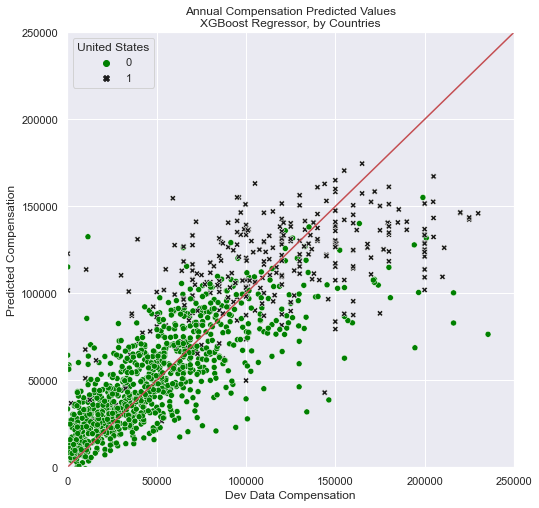

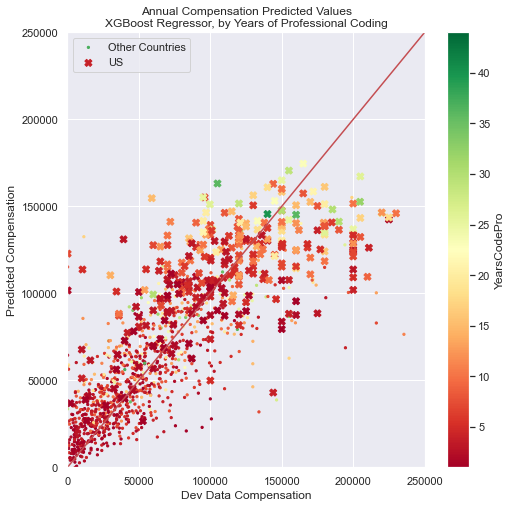

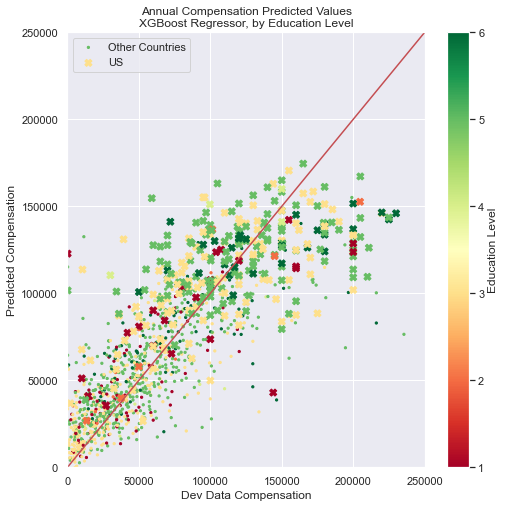

In [139]:
plot_predictions(X_dev, y_dev[:,0], y_dev_pred13, column_name='United States', 
                 title='XGBoost Regressor, by Countries')    
plot_predictions(X_dev, y_dev[:,0], y_dev_pred13, column_name='YearsCodePro', 
                 title='XGBoost Regressor, by Years of Professional Coding')
plot_predictions(X_dev, y_dev[:,0], y_dev_pred13, column_name='ed_ordinal', 
                 title='XGBoost Regressor, by Education Level')

**Comment:**
- We could see the spreading of the predicted values is improved (less spread out) in XGBoost model. However, it still under predicts the values of compensation that are more than \$150K (similar to the base model). This is a hard problem for future work that will require collecting additional features like industry, state information, number of working hours, as well as using different features engineering approaches to improve the model performance (i.e., grouping the skill sets and education levels differently). 

#### 6.6. Support Vector Regression
- In this section, we built different support vector regression models with different kernel (linear, rbf and poly) to see if non-linear approach could be helpful for our models.

In [53]:
## Support Vector Regression
# Tuning Parameters 
params = [{'kernel':['rbf','poly'], 'C':[ 0.5, 1, 10, 100], 'gamma':[0.001, 0.005, 0.01, 0.1], 'epsilon':[0.001, 0.01]},
          {'kernel':['linear'], 'C':[0.5, 1, 10, 100], 'epsilon':[0.001, 0.01]}]

gs7 = GridSearchCV(SVR(), n_jobs=-1,
                   param_grid=params, cv=5, scoring='r2')
gs7.fit(X_train_std, y_train[:,0])
y_train_pred7 = gs7.best_estimator_.predict(X_train_std)
y_dev_pred7 = gs7.best_estimator_.predict(X_dev_std)

print('## Support Vector Regression:')
print('\nBest kernel:', gs7.best_params_['kernel'])
print('Best C:', gs7.best_params_['C'])
# print('Best gamma:', gs7.best_params_['gamma'])
print('Best epsilon:', gs7.best_params_['epsilon'])
print('Best Estimator:', gs7.best_estimator_)
model_evaluation(X_train_std, y_train, y_train_pred7, X_dev_std, y_dev, y_dev_pred7)

## Support Vector Regression:

Best kernel: linear
Best C: 100
Best epsilon: 0.001
Best Estimator: SVR(C=100, epsilon=0.001, kernel='linear')

RMSE train: 32480.08
RMSE test: 30439.58

R2 Score train: 0.583
R2 Score test: 0.625

Adjusted R2 Score train: 0.577
Adjusted R2 Score test: 0.601


**Comment:**
- The best SVR model returned has linear kernel, and the perfomance is actually worse than the base model for R2 score (reduce from 0.632 to 0.625), and RMSE (increase from \\$30,144 to \\$30,439). This indicates that we could not improve our model with non-linear approaches.

#### 6.7. Feature Extraction with PCA
- In the following sections, we will perform dimensionality reduction using principal component analysis (PCA) to evaluate our model.

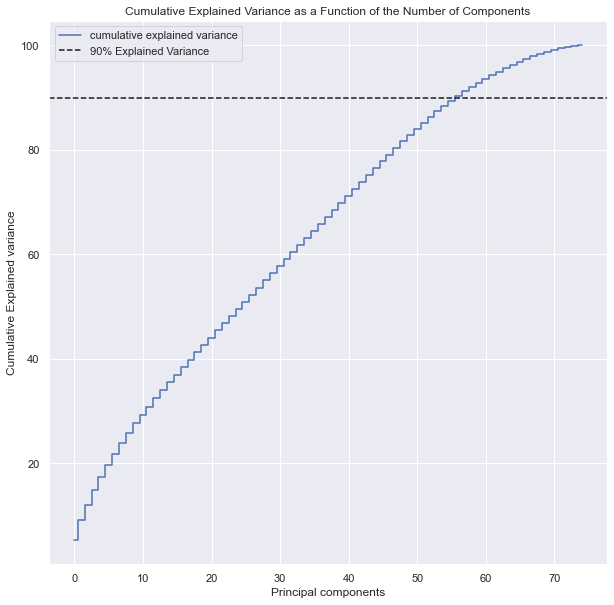

In [55]:
# PCA Plotting 
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
x_axis = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.step(x_axis, cumsum, where='mid', label='cumulative explained variance') 
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance')
plt.legend(loc='best')

**Comment:**
- The cummulative explained variance shows there is no strong relationship between our features and target. The cummulative explained variance almost linearly increases with adding number of principal components. Our model has high bias and low variance and more likely to suffer from under-fitting rather than over-fitting.

## Regression Using PCA for Feature Extraction:

 PCA_Components  RMSE_train  RMSE_test  R2_Score_train  R2_Score_test
            2.0    43358.24   42375.06           0.256          0.274
            5.0    39557.28   37992.67           0.381          0.416
           10.0    36739.58   35225.77           0.466          0.498
           20.0    35287.31   34058.94           0.507          0.531
           30.0    34311.96   32962.93           0.534          0.561
           40.0    33754.69   32216.63           0.549          0.580
           50.0    32994.86   31449.84           0.569          0.600
           60.0    32717.61   31209.58           0.577          0.606
           75.0    31794.68   30144.14           0.600          0.632


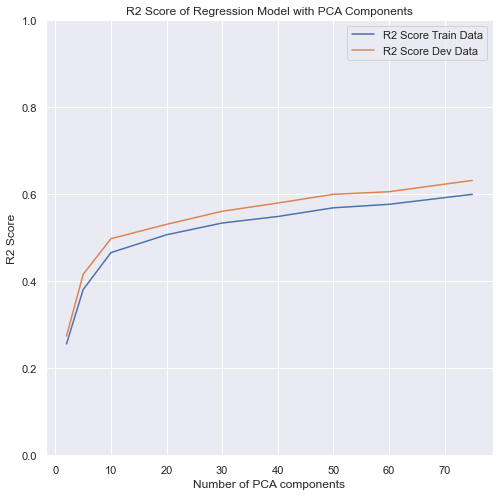

In [209]:
# Apply PCA:
from sklearn.pipeline import Pipeline
n_pcas = [2, 5, 10, 20, 30, 40, 50, 60, 75]
rmse_model8_train = []
rmse_model8_test = []
r2_model8_train = []
r2_model8_test = []

for n in n_pcas:
    lr8 = Pipeline([('pca', PCA(n_components=n,random_state=42)), 
                      ('lr',LinearRegression())])

    lr8.fit(X_train_std,y_train[:,0])
    y_train_pred8 = lr8.predict(X_train_std)
    y_dev_pred8 = lr8.predict(X_dev_std)
    rmse_model8_train.append(round(np.sqrt(mean_squared_error(y_train[:,0], y_train_pred8)),2))
    rmse_model8_test.append(round(np.sqrt(mean_squared_error(y_dev[:,0], y_dev_pred8)),2))
    r2_model8_train.append(round(lr8.score(X_train_std, y_train[:,0]),3))
    r2_model8_test.append(round(lr8.score(X_dev_std, y_dev[:,0]),3))
    
df_model8 = pd.DataFrame([n_pcas, rmse_model8_train, rmse_model8_test, r2_model8_train, r2_model8_test]).T
df_model8.columns = ['PCA_Components', 'RMSE_train', 'RMSE_test', 'R2_Score_train', 'R2_Score_test'] 

print('## Regression Using PCA for Feature Extraction:\n')
print(df_model8.to_string(index=False))

# Plot result with R2
plt.figure(figsize=(8, 8))
plt.plot(df_model8.PCA_Components, df_model8.R2_Score_train, label='R2 Score Train Data') 
plt.plot(df_model8.PCA_Components, df_model8.R2_Score_test, label='R2 Score Dev Data') 
plt.title('R2 Score of Regression Model with PCA Components')
plt.ylabel('R2 Score')
plt.ylim((0, 1))
plt.xlabel('Number of PCA components')
plt.legend(loc='best')
plt.show()


**Comment:**
- Using 50 PCA components (about 90% explained variance) could be a good approach for dimensionality reduction. The R2 and RMSE is quite close to the base model (with 75 components)
- In the next section we will run 50 PCA components with our best model so far - the XGBoost

In [138]:
## Run PCA & XGBoost
# Tuning parameters max depth, min sample split, number of estimators and learning rate
params = {'xgb__max_depth':[3, 10, 30, 50], 'xgb__colsample_bytree': [0.3, 0.5, 0.7], 'xgb__lambda':[1, 10, 100, 1000],
          'xgb__n_estimators':[50, 100, 150], 'xgb__learning_rate':[0.01, 0.1, 1],
         'pca__n_components':[50]}

model9 = Pipeline([('pca', PCA(random_state=42)),
                ('xgb', xgb.XGBRegressor(objective ='reg:squarederror', random_state=42))])
                    
gs9 = GridSearchCV(model9, n_jobs=-1,
                   param_grid=params, cv=5, scoring='r2')

gs9.fit(X_train, y_train[:,0])
y_train_pred9 = gs9.best_estimator_.predict(X_train)
y_dev_pred9 = gs9.best_estimator_.predict(X_dev)


# Evaluation
print('## Regression with XGBoost and PCA:')
print('\nBest max_depth:', gs9.best_params_['xgb__max_depth'])
print('Best colsample_bytree:', gs9.best_params_['xgb__colsample_bytree'])
print('Best L2 regularization:', gs9.best_params_['xgb__lambda'])
print('Best n_estimators:', gs9.best_params_['xgb__n_estimators'])
print('Best learning_rate:', gs9.best_params_['xgb__learning_rate'])
print('PCA n_components:', gs9.best_params_['pca__n_components'])
print('Best Estimator:', gs9.best_estimator_)
model_evaluation(X_train, y_train, y_train_pred9, X_dev, y_dev, y_dev_pred9)

## Regression with XGBoost and PCA:

Best max_depth: 3
Best colsample_bytree: 0.3
Best L2 regularization: 1
Best n_estimators: 150
Best learning_rate: 0.1
PCA n_components: 50
Best Estimator: Pipeline(steps=[('pca', PCA(n_components=50, random_state=42)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.3, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', lambda=1,
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=150,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=0, reg_lambd

**Comment:**
- XGBoost could only slightly improve the performance for the models using 50 PCA components (R2 from 0.600 to 0.618). We could see that using PCA for dimensionality reduction is not a good approach in this case. 

### 6.8 Feature Selection Using Random Forest Regressor
- In the following sections, we will use the random forest regressor models build in step 6.5 to choose the most important features of our model, and evaluate the model performance using different numbers of the most important features. 

## Regression with The Top n Important Features:

 Feature_Number  RMSE_train  RMSE_test  R2_Score_train  R2_Score_test
            2.0    38765.38   37963.16           0.406          0.417
            5.0    36385.31   34775.57           0.476          0.511
           10.0    34461.56   32805.05           0.530          0.565
           20.0    33494.93   31874.64           0.556          0.589
           30.0    33052.14   31481.92           0.568          0.599
           40.0    32290.60   30594.95           0.588          0.621
           50.0    32057.17   30311.20           0.594          0.628
           60.0    31901.55   30186.50           0.597          0.631
           75.0    31794.68   30144.14           0.600          0.632


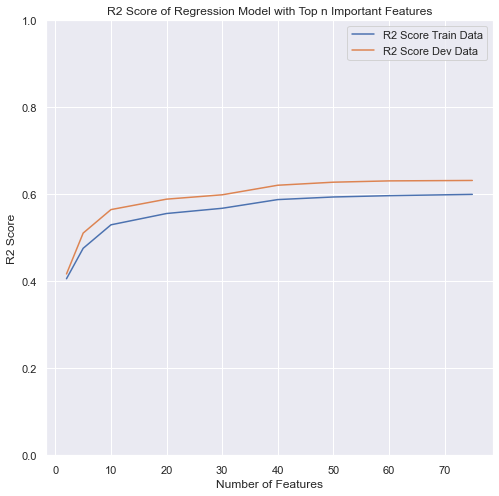

In [211]:
# Apply Feature Selection from Random Forest Regressor:
n_features = [2, 5, 10, 20, 30, 40, 50, 60, 75]  
rmse_model10_train = []
rmse_model10_test = []
r2_model10_train = []
r2_model10_test = []

# Get Feature importances
feature_importance = gs6.best_estimator_.feature_importances_
feature_names = X.columns

# Regression with the most n important features 
for n in n_features:
    # find the column index of the n most 
    top_n_index = np.flip(np.argsort(feature_importance)[-n:])
    
    # Subset X data to top n most important features
    X_train_n = X_train[:,top_n_index]
    X_dev_n = X_dev[:,top_n_index]
    
    # Model Predictions
    lr10 = LinearRegression()
    lr10.fit(X_train_n, y_train[:,0])
    y_train_pred10 = lr10.predict(X_train_n)
    y_dev_pred10 = lr10.predict(X_dev_n)
    
    # Add evaluations to return list
    rmse_model10_train.append(round(np.sqrt(mean_squared_error(y_train[:,0], y_train_pred10)),2))
    rmse_model10_test.append(round(np.sqrt(mean_squared_error(y_dev[:,0], y_dev_pred10)),2))
    r2_model10_train.append(round(lr10.score(X_train_n, y_train[:,0]),3))
    r2_model10_test.append(round(lr10.score(X_dev_n, y_dev[:,0]),3))
    
df_model10 = pd.DataFrame([n_features, rmse_model10_train, rmse_model10_test, r2_model10_train, r2_model10_test]).T
df_model10.columns = ['Feature_Number', 'RMSE_train', 'RMSE_test', 'R2_Score_train', 'R2_Score_test'] 

print('## Regression with The Top n Important Features:\n')
print(df_model10.to_string(index=False))

# Plot result with R2
plt.figure(figsize=(8, 8))
plt.plot(df_model10.Feature_Number, df_model10.R2_Score_train, label='R2 Score Train Data') 
plt.plot(df_model10.Feature_Number, df_model10.R2_Score_test, label='R2 Score Dev Data') 
plt.title('R2 Score of Regression Model with Top n Important Features')
plt.ylabel('R2 Score')
plt.ylim((0, 1))
plt.xlabel('Number of Features')
plt.legend(loc='best')
plt.show()

**Comment:**
- We could see that by using 30 most important features with linear regression, our model performs almost equivalent to using 50 PCA components with XGBoost. 
- Using feature selection is a better approach than using PCA in this project.
- We will look further into using the most 30 important features and check if there any indication of a non-linear relationship exist for the 30 features with the compensation.

In [82]:
# Top 30 important features
top_index30 = np.flip(np.argsort(feature_importance)[-30:])
top30_features = feature_names[top_index30]
print('Top 30 Important Features name:\n')
print(top30_features)
print('\nTop 30 Feature Importances:\n')
print(np.flip(np.sort(feature_importance)[-30:]))

Top 30 important features name:

Index([     'United States',       'YearsCodePro',                'Age',
                   'Yearly',              'India',             'Israel',
                  'OrgSize',        'Switzerland',         'ed_ordinal',
          'cloud_computing',     'nosql_database',            'web_dev',
             'sql_database',            'Denmark',           'ML_tools',
                    'white',        'language_DS',         'Age1stCode',
                   'employ',            'Germany',    'language_others',
            'web_framework',             'Weekly', 'server_dist_config',
       'container_platform',                 2021,              'Spain',
           'United Kingdom',       'command_line',         'app_UI_dev'],
      dtype='object')

Top 30 feature importance:

[0.42849663 0.12372622 0.06398234 0.06207453 0.04354027 0.03794268
 0.02409672 0.01399906 0.01335941 0.01211191 0.01199881 0.0117345
 0.01095817 0.00954074 0.00905964 0.00900909 0.00816

In [83]:
## Subset X data to top 30 with most feature_importance
X_train_top30 = X_train[:,top_index]
X_train_std_top30 = X_train_std[:,top_index]
X_dev_top30 = X_dev[:,top_index]
X_dev_std_top30 = X_dev_std[:,top_index]
print('Dimension of X_train data with top 30 features:', X_train_top30.shape)
print('Dimension of X_dev data with top 30 features:', X_dev_top30.shape)

Dimension of X_train data with top 30 features: (5831, 30)
Dimension of X_dev data with top 30 features: (1250, 30)


In [174]:
# Regression with top 30 features:
lr10 = LinearRegression()
lr10.fit(X_train_top30, y_train[:,0])
y_train_pred10 = lr10.predict(X_train_top30)
y_dev_pred10 = lr10.predict(X_dev_top30)

# Evaluation
print('## Linear Regression - with 30 most important features:')
model_evaluation(X_train_top30, y_train, y_train_pred10, X_dev_top30, y_dev, y_dev_pred10)

## Linear Regression - with 30 most important features:

RMSE train: 33052.14
RMSE test: 31481.92

R2 Score train: 0.568
R2 Score test: 0.599

Adjusted R2 Score train: 0.566
Adjusted R2 Score test: 0.589


Text(0.5, 0, 'Prediction - Compensation')

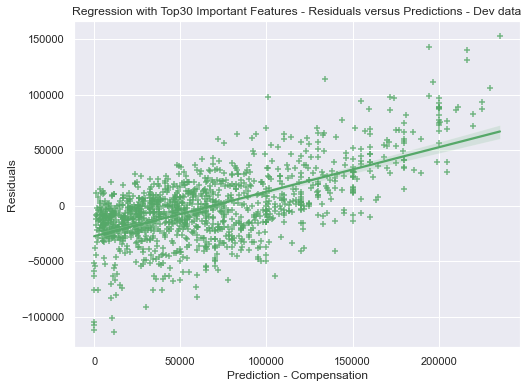

In [176]:
## Checking for Linear Conditional Expection to see if we need Polynomial Transformation or not
# Calculate residuals versus predictions
resid10 = y_dev[:,0] - y_dev_pred10

# Plot
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(y_dev[:,0], resid10, color='g', marker='+')
plt.title('Regression with Top30 Important Features - Residuals versus Predictions - Dev data')
plt.ylabel('Residuals')
plt.xlabel('Prediction - Compensation')

# The plot indicates the linear conditional expectation could be compromised, 
# The model predicts lower values (undershoot) when under 100K, and higher values (overshoot) when above 100K 
# Looks like heavy tail affect the performance of the model

**Comment:**
- The plot indicates the linear conditional expectation could be compromised, the model predicts lower values (undershoot) when salary is under \\$100K, and higher values (overshoot) when above \\$100K. It seems that heavy tail data is likely to affect the performance of the model.

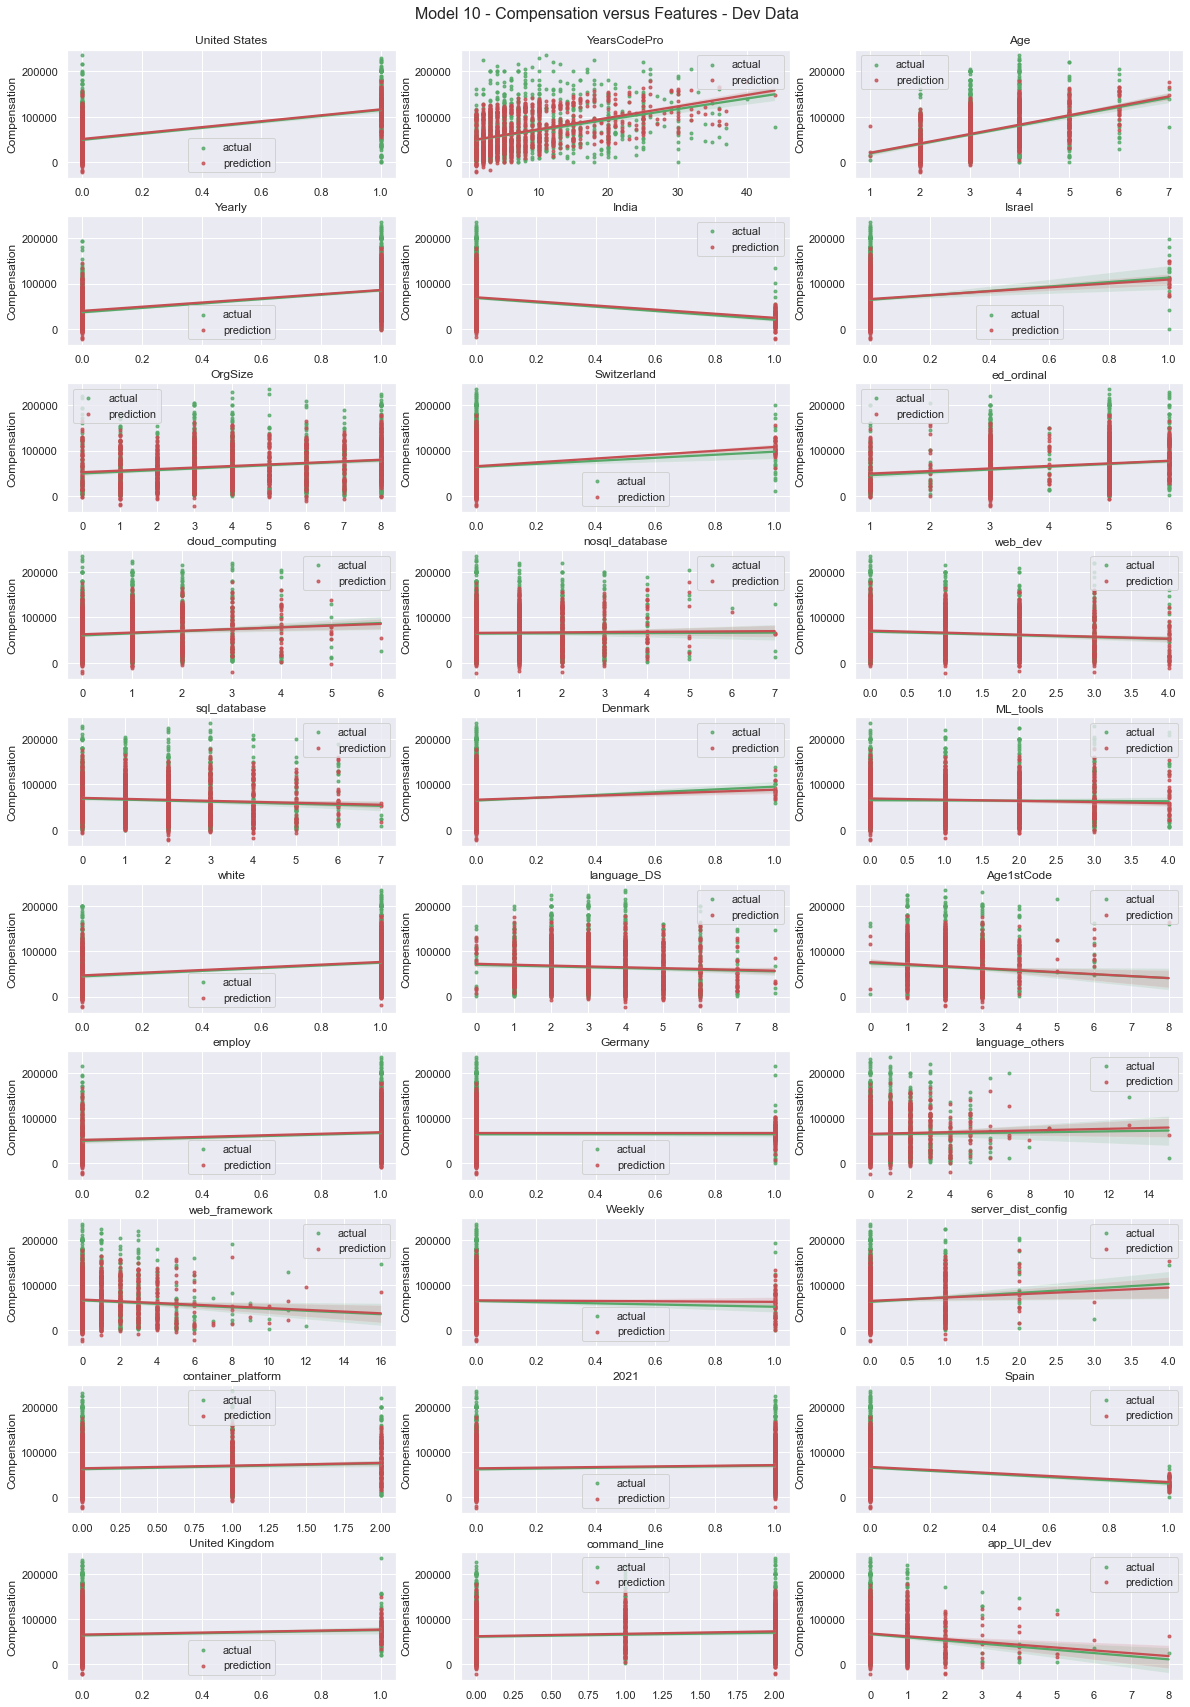

In [215]:
## Check Linear Conditional Expection for the 30 most important features to see which one is not linear
fig = plt.figure(figsize=(20,30))
plt.suptitle('Model 10 - Compensation versus Features - Dev Data', size=16, y = 0.9)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
i = 1
for idx in range(len(top30_features)):
    plt.subplot(10, 3, i)
    sns.regplot(X_dev_top30[:,idx], y_dev[:,0], color='g', marker='.', label='actual')
    sns.regplot(X_dev_top30[:,idx], y_dev_pred10, color='r', marker='.', label='prediction')
    plt.legend()
    plt.ylabel('Compensation')
    plt.title(top30_features[idx])
#     plt.xlabel(top30_features[idx])
    i += 1
    
# From the plots: there is no indication of non-linear relationship for any features

**Comment:**
- From the plots: there is no indication of non-linear relationship for any features. Therefore, no further transformation of the features is needed.
- The skill-sets in this dataset does not provide good insight to predict the salary for data scientist. They are mostly no effect or have negative trend with compensation, which is not as what we expected when starting the project.

#### 6.9.  Model Training - United States
- In the following sections, we will use US only data and evaluate the model performance

In [122]:
# Overview of features for US only
X_US.head()

OrgSize  Age1stCode  YearsCodePro  Age  language_DS  language_others  \
3         8           2             5    3            3                2   
5         3           2             1    3            3                1   
9         1           2             9    3            4                3   
19        8           0             6    4            2                0   
30        4           1            20    4            2                1   

    command_line  web_dev  sql_database  nosql_database  cloud_computing  \
3              1        2             3               0                3   
5              1        1             0               0                1   
9              0        0             1               2                1   
19             1        0             2               0                2   
30             1        2             2               0                1   

    elec_platform  container_platform  web_framework  ML_tools  app_UI_dev  \
3               0                   0              1         0           0   
5               0                   0              0         0           0   
9               0                   0              2         1           1   
19              0                   0              0         0           0   
30              0                   0              4         0           0   

    server_dist_config  man  woman  sexualitycat  transbin  ed_ordinal  \
3                    0    1      0             0         0           3   
5                    0    1      0             0         0           6   
9                    0    1      0             0         0           5   
19                   0    1      0             0         0           6   
30                   0    1      0             0         0           3   

    employ  employ_parttime  white  asian  black  mideast  hispanic  biracial  \
3        1                0      0      0      0        0         0         0   
5        1                0      0      1      0        0         0         0   
9        1                0      1      0      0        0         0         0   
19       1                0      1      0      0        0         0         0   
30       1                0      1      0      0        0         0         0   

    2020  2021  
3      0     1  
5      0     1  
9      0     1  
19     0     1  
30     0     1

## Linear Regression - Base Model - US Only:

RMSE train: 40859.75
RMSE test: 41957.68

R2 Score train: 0.277
R2 Score test: 0.188

Adjusted R2 Score train: 0.260
Adjusted R2 Score test: 0.090


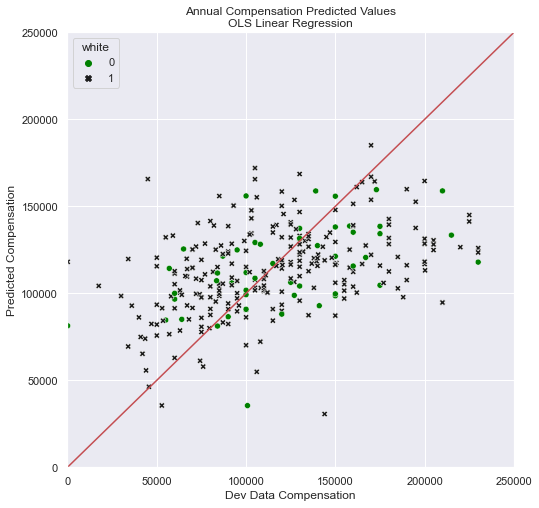

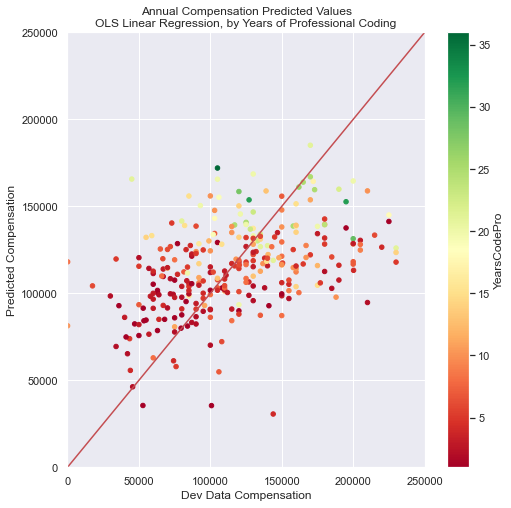

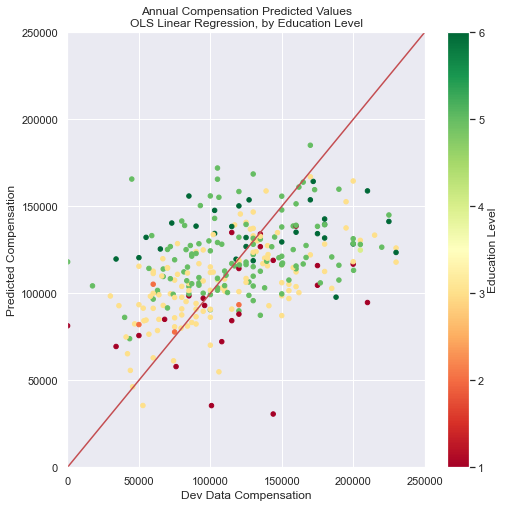

In [140]:
## Base Model US - No transformation
# Base Model Training
lr_US = LinearRegression()
lr_US.fit(X_train_US, y_train_US[:,0])
y_train_pred_US = lr_US.predict(X_train_US)
y_dev_pred_US = lr_US.predict(X_dev_US)

# Function for plotting US data Only
def plot_predictions_US(X_dev, y_dev, y_dev_pred, column_name, title):
    column_idx = X.columns.tolist().index(column_name)
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if column_idx in range(17) or column_idx==21:
        plt.scatter(y_dev, y_dev_pred, c=X_dev[:, column_idx], 
                        cmap="RdYlGn", s=20, alpha=1, marker='o', edgecolors=None,
                        vmin=X_dev[:,column_idx].min(), vmax=X_dev[:,column_idx].max())
        cbar = plt.colorbar(ax=ax)
        if column_name == 'ed_ordinal':
            column_name = 'Education Level'
        cbar.set_label(column_name)
    else:
        # Plot binary Column
        sns.scatterplot(y_dev, y_dev_pred, hue=X_dev[:,column_idx], style=X_dev[:,column_idx],
                       palette=['green','k'])
        ax.legend(title=column_name)

        
    ax.set_title("Annual Compensation Predicted Values\n" + title)
    ax.set_ylabel("Predicted Compensation")
    ax.set_xlabel("Dev Data Compensation")
    ax.set_ylim(0,250000)
    ax.set_xlim(0,250000)
    ax.plot(np.linspace(0,250000, 5),np.linspace(0,250000, 5), '-r')

    plt.show()

# Model evaluation
print('## Linear Regression - Base Model - US Only:')
model_evaluation(X_train_US, y_train_US, y_train_pred_US, X_dev_US, y_dev_US, y_dev_pred_US)
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred_US, column_name='white', 
                 title='OLS Linear Regression')    
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred_US, column_name='YearsCodePro', 
                 title='OLS Linear Regression, by Years of Professional Coding')
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred_US, column_name='ed_ordinal', 
                 title='OLS Linear Regression, by Education Level')

**Comment:**
- When subsetting the data to include US records only, our model's performance is significantly reduce, both in R2 score and RMSE. The base model for US only has low R2 of 0.188 and high RMSE of \\$41,957

In [128]:
# Transform compensation to Log Scale - US Only
lr2_US = LinearRegression()
lr2_US.fit(X_train_US, np.log(y_train_US[:,0]))
y_train_pred2_US = lr2_US.predict(X_train_US)
y_dev_pred2_US = lr2_US.predict(X_dev_US)

print('## Linear Regression - Transform Compensation to Log scale Model - US Only:')
model_evaluation_log(X_train_US, y_train_US, y_train_pred2_US, X_dev_US, y_dev_US, y_dev_pred2_US)

## Linear Regression - Transform Compensation to Log scale Model - US Only:

RMSE train: 43874.94
RMSE test: 44836.13

R2 Score train: 0.157
R2 Score test: 0.102

Adjusted R2 Score train: 0.137
Adjusted R2 Score test: -0.008


**Comment:**
- Log transform has very poor performance for US data only

In [129]:
## XGBoost - US Only
# Tuning parameters max depth, min sample split, number of estimators and learning rate
params = {'max_depth':[3, 10, 30, 50], 'colsample_bytree': [0.3, 0.5, 0.7], 'lambda':[1, 10, 100, 1000],
          'n_estimators':[50, 100, 150], 'learning_rate':[0.01, 0.1, 1]}

xgb3_US= xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
gs3_US = GridSearchCV(xgb3_US, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs3_US.fit(X_train_US,y_train_US[:,0])
y_train_pred3_US = gs3_US.best_estimator_.predict(X_train_US)
y_dev_pred3_US = gs3_US.best_estimator_.predict(X_dev_US)

# Evaluation
print('## Regression with XG Boosting - US Only:')
print('\nBest max_depth:', gs3_US.best_params_['max_depth'])
print('Best colsample_bytree:', gs3_US.best_params_['colsample_bytree'])
print('Best L2 regularization:', gs3_US.best_params_['lambda'])
print('Best n_estimators:', gs3_US.best_params_['n_estimators'])
print('Best learning_rate:', gs3_US.best_params_['learning_rate'])
print('Best Estimator:', gs3_US.best_estimator_)
model_evaluation(X_train_US, y_train_US, y_train_pred3_US, X_dev_US, y_dev_US, y_dev_pred3_US)

## Regression with XG Boosting - US Only:

Best max_depth: 3
Best colsample_bytree: 0.7
Best L2 regularization: 100
Best n_estimators: 150
Best learning_rate: 0.1
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=100, learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

RMSE train: 36174.74
RMSE test: 41525.67

R2 Score train: 0.433
R2 Score test: 0.205

Adjusted R2 Score train: 0.420
Adjusted R2 Score test: 0.108


**Comment:**
- XGBoost with US data only could only improve the model very slightly comparing to the US baseline model.

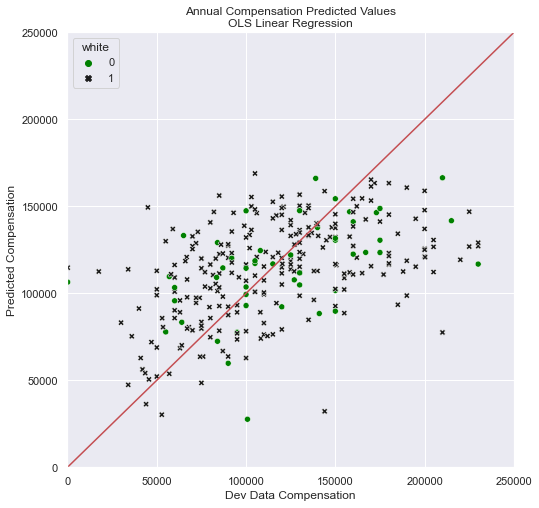

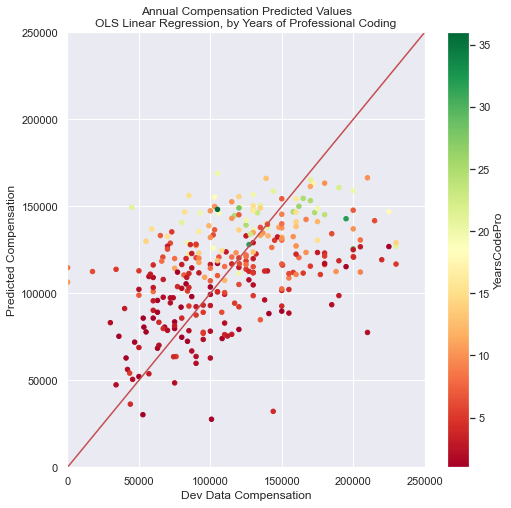

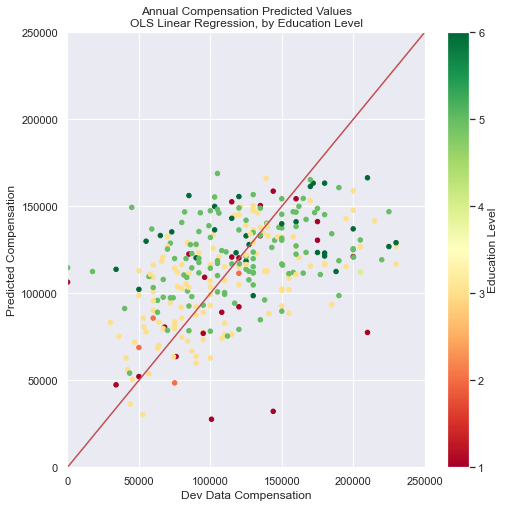

In [141]:
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred3_US, column_name='white', 
                 title='OLS Linear Regression')    
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred3_US, column_name='YearsCodePro', 
                 title='OLS Linear Regression, by Years of Professional Coding')
plot_predictions_US(X_dev_US, y_dev_US[:,0], y_dev_pred3_US, column_name='ed_ordinal', 
                 title='OLS Linear Regression, by Education Level')

In [132]:
## Support Vector Regression - US Only
# Tuning Parameters 
params = [{'kernel':['rbf','poly'], 'C':[ 0.5, 1, 10, 100], 'gamma':[0.001, 0.005, 0.01, 0.1], 'epsilon':[0.001, 0.01]},
          {'kernel':['linear'], 'C':[0.5, 1, 10, 100], 'epsilon':[0.001, 0.01]}]

gs4_US = GridSearchCV(SVR(), n_jobs=-1,
                   param_grid=params, cv=5, scoring='r2')
gs4_US.fit(X_train_std_US, y_train_US[:,0])
y_train_pred4_US = gs4_US.best_estimator_.predict(X_train_std_US)
y_dev_pred4_US = gs4_US.best_estimator_.predict(X_dev_std_US)

print('## Support Vector Regression - US Only:')
print('\nBest kernel:', gs4_US.best_params_['kernel'])
print('Best C:', gs4_US.best_params_['C'])
# print('Best gamma:', gs7.best_params_['gamma'])
print('Best epsilon:', gs4_US.best_params_['epsilon'])
print('Best Estimator:', gs4_US.best_estimator_)
model_evaluation(X_train_std, y_train_US, y_train_pred4_US, X_dev_std, y_dev_US, y_dev_pred4_US)

## Support Vector Regression - US Only:

Best kernel: linear
Best C: 100
Best epsilon: 0.01
Best Estimator: SVR(C=100, epsilon=0.01, kernel='linear')

RMSE train: 41355.29
RMSE test: 42155.83

R2 Score train: 0.259
R2 Score test: 0.181

Adjusted R2 Score train: 0.249
Adjusted R2 Score test: 0.128


**Comment:**
- SVR with US data also returns in the best model with linear kernel, and the performance is worst than US baseline model.

### Step 7: Final Model Prediction
- In this section we will evaluate our final model - XGBoost using the test data

In [189]:
# Predict compensation with XGBoostRegressor Best Model
# Best model overview
gs13.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=100, learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [207]:
# Predict test data
y_test_pred = gs13.best_estimator_.predict(X_test)
print('RMSE test data: %.2f' %np.sqrt(mean_squared_error(y_test[:,0], y_test_pred)))
print('R2 Score test data: %.3f' %r2_score(y_test[:,0], y_test_pred))

RMSE test data: 26919.16
R2 Score test data: 0.714


**Comment:**
- Using the best model with XGBoost, we were able to achieve R2 score of 0.714 and RMSE \\$26,919 for our test data. 

### Step 8: Conclusion
<br>

#### Best Model
- Using XGBoost Regressor with all 75 features for all countries in the dataset. 
- Best model performance:

<br>

|       Model          | RMSE Test Data | R2 Score Test Data |
|:---------------------|--------------:|--------------------:|
| XGBoosting Regressor |     26,919.16 |               0.714 |

<br>

|         Model        | RMSE Dev Data | R2 Score Dev Data |                                      Hyperparameters Tuning                                 |
|:---------------------|--------------:|------------------:|:--------------------------------------------------------------------------------------------|
| XGBoosting Regressor |     29,166.97 |             0.656 | max_depth=10, n_estimators=150, <br>colsample_bytree=0.5, lambda=100, <br>learning_rate=0.1 |

<br><br>
